# Predict Future Sales

In [175]:
!pip install koreanize_matplotlib

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import re
import koreanize_matplotlib
from itertools import product

warnings.filterwarnings(action='ignore')

# 1.데이터 준비

## A. 데이터 불러오기

In [177]:
data_path = 'https://raw.githubusercontent.com/kestrel-git/quest/main/240723/data/'

df_sales_train = pd.read_csv(data_path + 'sales_train.csv')
df_shops = pd.read_csv(data_path + 'shops_translated.csv')
df_items = pd.read_csv(data_path + 'items.csv')
df_item_categories = pd.read_csv(data_path + 'item_categories_translated.csv')

df_test = pd.read_csv(data_path + 'test.csv')
df_sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

## B. 메모리 사용량 줄이기
- `sales_train` 데이터가 약 293만개로 134MB를 차지
- 작업 속도 향상을 위해 일부 데이터 타입을 변경하여 메모리 사용량을 줄임

In [178]:
# 데이터 타입 변경으로 메모리 사용량을 줄이는 함수
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [179]:
# 메모리 사용량 줄이기
df_all = [df_sales_train, df_shops, df_items, df_item_categories, df_test]
for df in df_all:
    df = downcast(df)

54.2% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


## C. 컬럼 이름을 한글로 변경
- 가독성을 위해 한글로 변경

In [180]:
df_sales_train = df_sales_train.rename(columns={'date': '날짜',
                                                'date_block_num': '월ID',
                                                'shop_id': '상점ID',
                                                'item_id': '상품ID',
                                                'item_price': '판매가',
                                                'item_cnt_day': '일간판매량'})

df_shops = df_shops.rename(columns={'shop_name': '상점명',
                                    'shop_id': '상점ID'})

df_items = df_items.rename(columns={'item_name': '상품명',
                                    'item_id': '상품ID',
                                    'item_category_id': '상품카테고리ID'})

df_item_categories = df_item_categories.rename(columns=
                                               {'item_category_name': '상품카테고리명',
                                                'item_category_id': '상품카테고리ID'})

df_test = df_test.rename(columns={'shop_id': '상점ID',
                                  'item_id': '상품ID'})

In [181]:
# 컬럼명이 잘 변경되었는지 확인
print(df_sales_train.columns)
print(df_shops.columns)
print(df_items.columns)
print(df_item_categories.columns)
print(df_test.columns)

Index(['날짜', '월ID', '상점ID', '상품ID', '판매가', '일간판매량'], dtype='object')
Index(['상점ID', '상점명'], dtype='object')
Index(['상품명', '상품ID', '상품카테고리ID'], dtype='object')
Index(['상품카테고리ID', '상품카테고리명'], dtype='object')
Index(['ID', '상점ID', '상품ID'], dtype='object')


# 2.데이터 탐색 및 전처리

## A. 데이터 요약

In [182]:
# 데이터 행/열 개수, 데이터 타입, 결측값 개수, 결측값 비율, 고윳값 개수, 1~3번째 값을 요약해서 보여주는 함수
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['결측값 비율'] = df.isnull().sum().values / len(df)
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    return summary

In [183]:
# 4개로 분리된 데이터를 하나로 요약해서 보기 위해 임시로 합침
df_temp_train = df_sales_train.merge(df_shops, on='상점ID', how='left')
df_temp_train = df_temp_train.merge(df_items, on='상품ID', how='left')
df_temp_train = df_temp_train.merge(df_item_categories, on='상품카테고리ID', how='left')

In [184]:
# 요약 정보 출력
resumetable(df_temp_train)

데이터셋 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,결측값 비율,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,날짜,object,0,0.00,1034,02.01.2013,03.01.2013,05.01.2013
1,월ID,int8,0,0.00,34,0,0,0
2,상점ID,int8,0,0.00,60,59,25,25
3,상품ID,int16,0,0.00,21807,22154,2552,2552
4,판매가,float64,0,0.00,19993,999.00,899.00,899.00
5,일간판매량,int16,0,0.00,198,1,1,-1
6,상점명,object,0,0.00,58,"야로슬라블, ""알타이르"" 쇼핑센터","모스크바, ""아트리움"" 쇼핑몰","모스크바, ""아트리움"" 쇼핑몰"
7,상품명,object,0,0.00,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP
8,상품카테고리ID,int8,0,0.00,84,37,58,58
9,상품카테고리명,object,0,0.00,83,영화 - Blu-Ray,음악 - 바이닐,음악 - 바이닐


## B. 수치형 변수 탐색

In [185]:
# 소수점 자릿수 지정
pd.options.display.float_format = '{:.2f}'.format

In [186]:
# 기술통계량 출력
df_temp_train.describe()

,월ID,상점ID,상품ID,판매가,일간판매량,상품카테고리ID
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [187]:
# 변수 정리
del df_temp_train
gc.collect()

11319

## C. 범주형 변수 탐색
- `상점명`: 첫 번째 단어가 상점이 위치한 도시를 나타냄
- `상품카테고리명`: 첫 번째 단어가 상품의 대분류를 나타냄

In [188]:
df_shops['상점명'].value_counts()

상점명
야쿠츠크, 오르조니키제, 56               2
야쿠츠크, "센터럴" 쇼핑센터               2
상트페테르부르크, "세나야" 쇼핑몰            1
모스크바, "세멘노프스키" 쇼핑센터            1
모스크바, "세레브랴니 돔" 쇼핑센터           1
므이티쉬, "XL-3" 쇼핑몰               1
니즈니노브고로드, "리오" 쇼핑센터            1
니즈니노브고로드, "판타스티카" 쇼핑센터         1
노보시비르스크, "갤러리아 노보시비르스크" 쇼핑몰    1
노보시비르스크, "메가" 쇼핑센터             1
옴스크, "메가" 쇼핑센터                 1
로스토프나도누, "메가센터 호리존트" 쇼핑몰       1
로스토프나도누, "메가센터 호리존트" 섬 매장      1
로스토프나도누, "메가" 쇼핑센터             1
상트페테르부르크, "네브스키 센터" 쇼핑몰        1
사마라, "멜로디아" 쇼핑센터               1
사마라, "파크하우스" 쇼핑센터              1
세르기예프 포사드, "7YA" 쇼핑센터          1
수르구트, "시티 몰" 쇼핑센터              1
톰스크, "에메랄드 시티" 쇼핑센터            1
튜멘, "크리스탈" 쇼핑몰                 1
튜멘, "구드윈" 쇼핑센터                 1
튜멘, "그린 쇼어" 쇼핑센터               1
우파, "센터럴" 쇼핑몰                  1
우파, "세미야" 쇼핑센터 2               1
힘키, "메가" 쇼핑센터                  1
디지털 창고 1C-온라인                  1
체홉, "카니발" 쇼핑센터                 1
모스크바, "페를로브스키" 쇼핑센터            1
모스크바, "노비 벡" 쇼핑센터 (노보코시노)      1
모스크바, 

In [189]:
df_item_categories['상품카테고리명'].value_counts().head()

상품카테고리명
선물 - 기념품            2
선물 - 가젯, 로봇, 스포츠    1
음악 - 선물 에디션         1
음악 - 뮤직 비디오         1
음악 - 바이닐            1
Name: count, dtype: int64

## D. 중복 데이터 처리
- 중복 데이터 6개 삭제

In [190]:
# 중복 데이터가 존재하는지 확인
print('df_sales_train 중복 데이터 개수:', df_sales_train.duplicated().sum())
print('df_shops 중복 데이터 개수:', df_shops.duplicated().sum())
print('df_items 중복 데이터 개수:', df_items.duplicated().sum())
print('df_item_categories 중복 데이터 개수:', df_item_categories.duplicated().sum())

df_sales_train 중복 데이터 개수: 6
df_shops 중복 데이터 개수: 0
df_items 중복 데이터 개수: 0
df_item_categories 중복 데이터 개수: 0


In [191]:
# df_sales_train의 중복 데이터 삭제
df_sales_train = df_sales_train.drop_duplicates(keep='first')

In [192]:
# 중복 데이터가 잘 삭제되었는지 확인
print('df_sales_train 중복 데이터 개수:', df_sales_train.duplicated().sum())
print('df_shops 중복 데이터 개수:', df_shops.duplicated().sum())
print('df_items 중복 데이터 개수:', df_items.duplicated().sum())
print('df_item_categories 중복 데이터 개수:', df_item_categories.duplicated().sum())

df_sales_train 중복 데이터 개수: 0
df_shops 중복 데이터 개수: 0
df_items 중복 데이터 개수: 0
df_item_categories 중복 데이터 개수: 0


## E. 결측치 처리
- 위의 데이터 요약표를 살펴본 결과, 결측치가 없어서 처리 안 함

## F. 이상치 처리

### a. `판매가` 컬럼 이상치 처리
- 음수 값 삭제: 가격이므로 음수가 존재해서는 안 됨
- 60,000을 넘는 값 삭제: 이상치로 보이는 큰 값 삭제

In [193]:
# 판매가 음수 값 삭제
df_sales_train = df_sales_train[df_sales_train['판매가'] > 0]

<Axes: xlabel='판매가'>

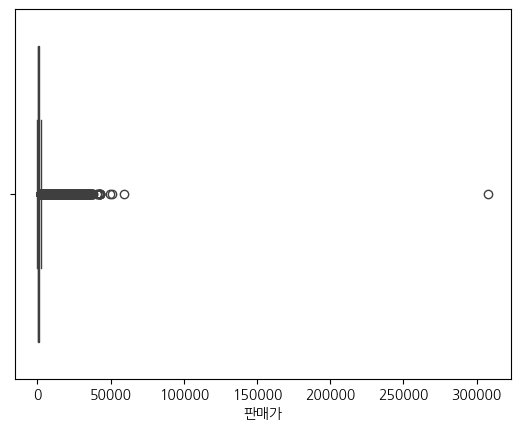

In [194]:
# 이상치 확인을 위해 박스플롯 그리기
sns.boxplot(data=df_sales_train, x='판매가')

In [195]:
# 값이 큰 순서로 살펴보기
df_sales_train['판매가'].sort_values(ascending=False).head(10)

1163158   307980.00
885138     59200.00
1488135    50999.00
2327159    49782.00
2910156    42990.00
2931380    42990.00
2885692    42990.00
2917760    42990.00
1006638    42000.00
2910155    41990.00
Name: 판매가, dtype: float64

In [196]:
# 판매가 이상치 삭제
df_sales_train = df_sales_train[df_sales_train['판매가'] < 60000]

### b. `일간판매량` 컬럼 이상치 처리
- 음수 값 삭제: 가격이므로 음수가 존재해서는 안 됨
- 1,000을 넘는 값 삭제: 이상치로 보이는 큰 값 삭제

In [197]:
# 일간판매량 음수 값 삭제
df_sales_train = df_sales_train[df_sales_train['일간판매량'] > 0]

<Axes: xlabel='일간판매량'>

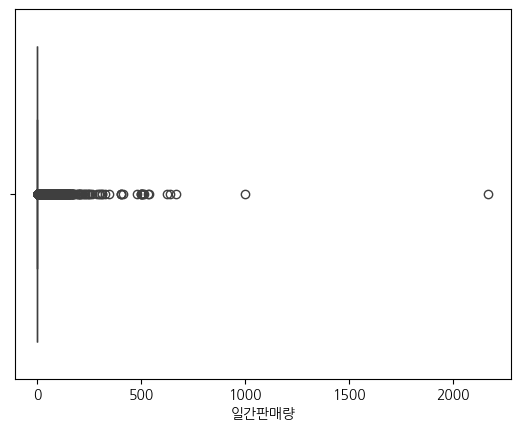

In [198]:
# 이상치 확인을 위해 박스플롯 그리기
sns.boxplot(data=df_sales_train, x='일간판매량')

In [199]:
# 값이 큰 순서로 살펴보기
df_sales_train['일간판매량'].sort_values(ascending=False).head(10)

2909818    2169
2326930    1000
2864235     669
2851091     637
2608040     624
2626181     539
2851073     533
2048518     512
2067669     508
2864260     504
Name: 일간판매량, dtype: int16

In [200]:
# 일간판매량 이상치 삭제
df_sales_train = df_sales_train[df_sales_train['일간판매량'] < 1000]

### c. 처리 결과 확인

In [201]:
# 4개로 분리된 데이터를 하나로 요약해서 보기 위해 임시로 합침
df_temp_train = df_sales_train.merge(df_shops, on='상점ID', how='left')
df_temp_train = df_temp_train.merge(df_items, on='상품ID', how='left')
df_temp_train = df_temp_train.merge(df_item_categories, on='상품카테고리ID', how='left')

# 이상치가 잘 처리되었는지 확인
df_temp_train.describe()

,월ID,상점ID,상품ID,판매가,일간판매량,상품카테고리ID
count,2928483.00,2928483.00,2928483.00,2928483.00,2928483.00,2928483.00
mean,14.57,33.00,10200.28,889.36,1.25,40.02
std,9.42,16.23,6324.39,1718.16,2.22,17.10
min,0.00,0.00,0.00,0.07,1.00,0.00
25%,7.00,22.00,4477.00,249.00,1.00,28.00
50%,14.00,31.00,9355.00,399.00,1.00,40.00
75%,23.00,47.00,15691.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,59200.00,669.00,83.00


In [202]:
# 변수 정리
del df_temp_train
gc.collect()

200

## G. 데이터 오류 수정

### a. 상점ID 수정
- 상점명을 보면 같은 상점인데 ID가 다른 경우가 있어서 상점 ID, 상점명 통일

In [203]:
# (1) 상점ID가 잘못된 경우 조회
df_shops[df_shops['상점명'].str.contains('39')]

,상점ID,상점명
10,10,"주코프스키, 츠칼로바 39m"
11,11,"주코프스키, 츠칼로바 39m²"


In [204]:
# train 데이터에서 상점ID 통일
df_sales_train.loc[df_sales_train['상점ID'] == 10, '상점ID'] = 11

# test 데이터에서 상점ID 통일
df_test.loc[df_test['상점ID'] == 10, '상점ID'] = 11

In [205]:
# (2) 상점ID가 잘못된 경우 조회
df_shops[df_shops['상점명'].str.contains('56')]

,상점ID,상점명
0,0,"야쿠츠크, 오르조니키제, 56"
57,57,"야쿠츠크, 오르조니키제, 56"


In [206]:
# train 데이터에서 상점ID 통일
df_sales_train.loc[df_sales_train['상점ID'] == 0, '상점ID'] = 57

# test 데이터에서 상점ID 통일
df_test.loc[df_test['상점ID'] == 0, '상점ID'] = 57

In [207]:
# (3) 상점ID가 잘못된 경우 조회
df_shops[df_shops['상점명'].str.contains('야쿠츠크, "센터럴" 쇼핑센터')]

,상점ID,상점명
1,1,"야쿠츠크, ""센터럴"" 쇼핑센터"
58,58,"야쿠츠크, ""센터럴"" 쇼핑센터"


In [208]:
# train 데이터에서 상점ID 통일
df_sales_train.loc[df_sales_train['상점ID'] == 1, '상점ID'] = 58

# test 데이터에서 상점ID 통일
df_test.loc[df_test['상점ID'] == 1, '상점ID'] = 58

In [209]:
# (4) 상점ID가 잘못된 경우 조회
df_shops[df_shops['상점명'].str.contains('메가센터 호리존트')]

,상점ID,상점명
39,39,"로스토프나도누, ""메가센터 호리존트"" 쇼핑몰"
40,40,"로스토프나도누, ""메가센터 호리존트"" 섬 매장"


In [210]:
# train 데이터에서 상점ID, 상점명 통일
df_sales_train.loc[df_sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 통일
df_test.loc[df_test['상점ID'] == 39, '상점ID'] = 40

## H. 컬럼 가공

### a. `상품카테고리명`에서 대분류만 남기기
- `상품카테고리명`의 앞 텍스트는 대분류 이름
- 더 적은 고윳값 수를 갖도록 대분류만 남김

In [211]:
# 처리 전 고윳값 확인
df_item_categories['상품카테고리명'].unique()

array(['PC - 헤드셋/이어폰', '액세서리 - PS2', '액세서리 - PS3', '액세서리 - PS4',
       '액세서리 - PSP', '액세서리 - PSVita', '액세서리 - XBOX 360',
       '액세서리 - XBOX ONE', '티켓 (디지털)', '상품 배송', '게임 콘솔 - PS2',
       '게임 콘솔 - PS3', '게임 콘솔 - PS4', '게임 콘솔 - PSP', '게임 콘솔 - PSVita',
       '게임 콘솔 - XBOX 360', '게임 콘솔 - XBOX ONE', '게임 콘솔 - 기타', '게임 - PS2',
       '게임 - PS3', '게임 - PS4', '게임 - PSP', '게임 - PSVita', '게임 - XBOX 360',
       '게임 - XBOX ONE', '게임 - 게임 액세서리', '게임 Android - 디지털',
       '게임 MAC - 디지털', '게임 PC - 추가 에디션', '게임 PC - 컬렉션 에디션',
       '게임 PC - 스탠다드 에디션', '게임 PC - 디지털', '결제 카드 (영화, 음악, 게임)',
       '결제 카드 - Live!', '결제 카드 - Live! (디지털)', '결제 카드 - PSN',
       '결제 카드 - Windows (디지털)', '영화 - Blu-Ray', '영화 - Blu-Ray 3D',
       '영화 - Blu-Ray 4K', '영화 - DVD', '영화 - 컬렉션', '책 - 아트북, 백과사전',
       '책 - 오디오북', '책 - 오디오북 (디지털)', '책 - 오디오북 1C', '책 - 비즈니스 서적',
       '책 - 만화, 만화책', '책 - 컴퓨터 서적', '책 - 1C 교육 자료', '책 - 엽서', '책 - 지식 서적',
       '책 - 여행 가이드', '책 - 문학 서적', '책 - 디지털', '음악 - 로컬 제작 CD',
       '음악 - 정

In [212]:
# 상품 카테고리 반환 함수
def get_main_item_category(category):
  res = category
  if '액세서리' in category:
    res = '게임 액세서리'
  elif '티켓' in category:
    res = '티켓'
  else:
    res = category.split('-')[0].strip()

  # 괄호 또는 특정 텍스트 이전 텍스트만 추출
  if len(res.split()) > 1:
    res = re.split('\(|Android|MAC|PC', res)[0].strip()

  return res

In [213]:
print('처리 전 고윳값 수:', df_item_categories['상품카테고리명'].nunique())

# 상품카테고리명에서 대분류를 의미하는 첫번째 단어만 추출하여 저장
df_item_categories['상품카테고리명_대분류'] = df_item_categories['상품카테고리명'].apply(get_main_item_category)

print('처리 후 고윳값 수:', df_item_categories['상품카테고리명_대분류'].nunique())

처리 전 고윳값 수: 83
처리 후 고윳값 수: 15


In [214]:
# 고윳값 확인
df_item_categories['상품카테고리명_대분류'].unique()

array(['PC', '게임 액세서리', '티켓', '상품 배송', '게임 콘솔', '게임', '결제 카드', '영화', '책',
       '음악', '선물', '프로그램', '서비스', '공 미디어', '배터리'], dtype=object)

In [215]:
# 잘 적용되었는지 확인
df_item_categories.head(3)

,상품카테고리ID,상품카테고리명,상품카테고리명_대분류
0,0,PC - 헤드셋/이어폰,PC
1,1,액세서리 - PS2,게임 액세서리
2,2,액세서리 - PS3,게임 액세서리


### b. `도시` 컬럼 추가
- `상점명` 피처의 앞 부분은 상점이 위치한 도시를 나타냄
- 지역에 따른 판매 차이가 있는지 확인을 위해 `도시` 컬럼 추가

In [216]:
# 처리 전 고윳값 확인
df_shops['상점명'].unique()

array(['야쿠츠크, 오르조니키제, 56', '야쿠츠크, "센터럴" 쇼핑센터', '아디게야, "메가" 쇼핑센터',
       '발라시하, "옥탸브르-키노미르" 쇼핑몰', '볼즈스키, "볼가 몰" 쇼핑센터', '볼로그다, "마르멜라드" 쇼핑센터',
       '보로네시, 플레하노프스카야 13', '보로네시, "막시미르" 쇼핑센터', '보로네시, 시티 파크 "그라드" 쇼핑센터',
       '방문 판매', '주코프스키, 츠칼로바 39m', '주코프스키, 츠칼로바 39m²', '인터넷 쇼핑몰',
       '카잔, "베헤틀레" 쇼핑센터', '카잔, "파크하우스" II 쇼핑센터', '칼루가, "21세기" 쇼핑센터',
       '콜롬나, "리오" 쇼핑센터', '크라스노야르스크, "브즐레트카 플라자" 쇼핑센터',
       '크라스노야르스크, "이윈" 쇼핑센터', '쿠르스크, "푸슈킨스키" 쇼핑센터', '모스크바, "세일"',
       '모스크바, "아피 몰" 쇼핑센터', '모스크바, S21 매장', '모스크바, "부데노프스키" 쇼핑센터 (A2관)',
       '모스크바, "부데노프스키" 쇼핑센터 (K7관)', '모스크바, "아트리움" 쇼핑몰',
       '모스크바, "아레알" 쇼핑센터 (벨랴예보)', '모스크바, "메가 벨라야 다차" II 쇼핑센터',
       '모스크바, "메가 뜨플리 스타니" II 쇼핑센터', '모스크바, "노비 벡" 쇼핑센터 (노보코시노)',
       '모스크바, "페를로브스키" 쇼핑센터', '모스크바, "세멘노프스키" 쇼핑센터',
       '모스크바, "세레브랴니 돔" 쇼핑센터', '므이티쉬, "XL-3" 쇼핑몰', '니즈니노브고로드, "리오" 쇼핑센터',
       '니즈니노브고로드, "판타스티카" 쇼핑센터', '노보시비르스크, "갤러리아 노보시비르스크" 쇼핑몰',
       '노보시비르스크, "메가" 쇼핑센터', '옴스크, "메가" 쇼핑센터', '로스토프나도누, "메가센터 호리존트" 쇼핑몰',
    

In [217]:
# 도시 이름 반환 함수
def get_city(shop_name):
  res = shop_name
  if '인터넷 쇼핑몰' in shop_name or '온라인' in shop_name:
    res = '온라인'
  else:
    res = shop_name.split(',')[0].strip()

  return res

In [218]:
# 상점명에서 도시를 의미하는 첫번째 단어만 추출
df_shops['도시'] = df_shops['상점명'].apply(get_city)

# 적용 결과 출력
print(df_shops['도시'].unique())

['야쿠츠크' '아디게야' '발라시하' '볼즈스키' '볼로그다' '보로네시' '방문 판매' '주코프스키' '온라인' '카잔'
 '칼루가' '콜롬나' '크라스노야르스크' '쿠르스크' '모스크바' '므이티쉬' '니즈니노브고로드' '노보시비르스크' '옴스크'
 '로스토프나도누' '상트페테르부르크' '사마라' '세르기예프 포사드' '수르구트' '톰스크' '튜멘' '우파' '힘키' '체홉'
 '야로슬라블']


In [219]:
# 잘 적용되었는지 확인
df_shops.head(3)

,상점ID,상점명,도시
0,0,"야쿠츠크, 오르조니키제, 56",야쿠츠크
1,1,"야쿠츠크, ""센터럴"" 쇼핑센터",야쿠츠크
2,2,"아디게야, ""메가"" 쇼핑센터",아디게야


### c. `첫판매월` 컬럼 추가
- 해당 상품이 처음 팔린 월을 나타냄
- 결측값은 그동안 한 번도 안 팔렸음을 의미하므로, 34로 대체 (2015년 11월)
  - 2015년 11월에도 안 팔렸다면 테스트 데이터에도 없는 것이므로 영향 없음

In [220]:
# 첫판매월 컬럼 추가
df_items['첫판매월'] = df_sales_train.groupby('상품ID').agg({'월ID': 'min'})['월ID']

# 결과 확인
df_items.head(3)

,상품명,상품ID,상품카테고리ID,첫판매월
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,20.00
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.00
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,19.00


In [221]:
# 결측값 확인
df_items['첫판매월'].isna().sum()

367

In [222]:
# 결측값을 34(2015년 11월)로 대체
df_items['첫판매월'].fillna(34)

0       20.00
1       15.00
2       19.00
3       18.00
4       20.00
         ... 
22165    7.00
22166    9.00
22167    8.00
22168    0.00
22169   14.00
Name: 첫판매월, Length: 22170, dtype: float64

### d. `상점명`, `상품명`, `상품카테고리명` 컬럼 삭제
- 유의미한 정보를 얻기 어려울 것으로 판단하여 삭제

In [223]:
# 삭제
df_shops = df_shops.drop(columns=['상점명'], axis=1)
df_items = df_items.drop(columns=['상품명'], axis=1)
df_item_categories = df_item_categories.drop(columns=['상품카테고리명'], axis=1)

In [224]:
# df_shops 결과 확인
df_shops.head(3)

,상점ID,도시
0,0,야쿠츠크
1,1,야쿠츠크
2,2,아디게야


In [225]:
# df_items 결과 확인
df_items.head(3)

,상품ID,상품카테고리ID,첫판매월
0,0,40,20.00
1,1,76,15.00
2,2,40,19.00


In [226]:
# df_item_categories 결과 확인
df_item_categories.head(3)

,상품카테고리ID,상품카테고리명_대분류
0,0,PC
1,1,게임 액세서리
2,2,게임 액세서리


## I. 월ID, 상점ID, 상품ID를 기준으로 데이터 정리
- 예측해야 하는 값이 상점의 상품별 월별 판매량이므로 이에 맞게 데이터 정리

### a. 월ID, 상점ID, 상품ID 조합 생성
- 월ID별로 한 번이라도 등장한 상점ID, 상품ID가 있다면 조합을 만듦

In [227]:
prod = [] # 생성된 조합을 담을 리스트
idx_cols = ['월ID', '상점ID', '상품ID'] # 기준 컬럼

# 월ID, 상점ID, 상품ID 조합을 만들어 리스트에 저장
for i in df_sales_train['월ID'].unique():
  shops = df_sales_train.loc[df_sales_train['월ID']==i, '상점ID'].unique()
  items = df_sales_train.loc[df_sales_train['월ID']==i, '상품ID'].unique()
  prod.append(np.array(list(product([i], shops, items))))

# 데이터프레임 형태로 변환
df_prod = pd.DataFrame(np.vstack(prod), columns=idx_cols)

In [228]:
# 잘 생성되었는지 확인
print('개수:', len(df_prod))
df_prod.head(3)

개수: 10812815


,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554


### b. 월간판매량, 월평균판매가 컬럼 추가
- 월ID, 상점ID, 상품ID 조합에 해당하는 월간판매량, 월평균판매가가 없는 경우 0으로 대체

In [229]:
# 월ID, 상점ID, 상품ID를 기준으로 그룹화하여 판매량 합 계산
df_monthly_agg = df_sales_train.groupby(idx_cols).agg({'일간판매량': 'sum',
                                                       '판매가': 'mean'})

# 인덱스 재설정 (인덱스로 지정된 그룹화 기준을 컬럼화)
df_monthly_agg = df_monthly_agg.reset_index()

# 컬럼 이름을 '월간판매량'으로 변경
df_monthly_agg = df_monthly_agg.rename(columns={'일간판매량': '월간판매량',
                                                '판매가': '월간평균판매가'})

In [230]:
# 잘 적용되었는지 확인
df_monthly_agg.head(3)

,월ID,상점ID,상품ID,월간판매량,월간평균판매가
0,0,2,27,1,2499.00
1,0,2,33,1,499.00
2,0,2,317,1,299.00


In [231]:
# 월ID, 상점ID, 상품ID를 기준으로 left 방식으로 합침
df_prod = df_prod.merge(df_monthly_agg, on=idx_cols, how='left')

# 결과 확인
df_prod.head(3)

# 변수 정리
del df_monthly_agg
gc.collect()

0

In [232]:
# 월간판매량, 평균판매가 결측값을 0으로 대체
df_prod['월간판매량'] = df_prod['월간판매량'].fillna(0)
df_prod['월간평균판매가'] = df_prod['월간평균판매가'].fillna(0)

# 결과 확인
df_prod.head(3)

,월ID,상점ID,상품ID,월간판매량,월간평균판매가
0,0,59,22154,1.00,999.00
1,0,59,2552,0.00,0.00
2,0,59,2554,0.00,0.00


### c. 테스트 데이터 이어붙이기
- 테스트 데이터에는 현재 `상점ID`, `상품ID` 컬럼만 존재
- 테스트 데이터에서도 상점, 상품, 상품카테고리 등의 추가 정보를 활용하기 위해 이어붙였다가 나중에 다시 분리할 예정
- 분리할 때 테스트 데이터임을 구분할 수 있도록 월ID를 34로 설정
- 테스트 데이터의 결측값(월간판매량, 월간평균판매가, 판매건수)은 판매되지 않아 데이터가 없는 것이므로 0으로 대체

In [233]:
# 테스트용 데이터 형태 확인
df_test.head(3)

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [234]:
# 테스트 데이터의 '월ID'를 34로 설정
df_test['월ID'] = 34

# 결과 확인
df_test.head(3)

,ID,상점ID,상품ID,월ID
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34


In [235]:
# 조합 데이터프레임과 테스트 데이터 이어붙이기
df_prod_test = pd.concat([df_prod, df_test.drop('ID', axis=1)],
                          ignore_index=True, # 기존 인덱스 무시 (0부터 새로 시작)
                          keys=idx_cols) # 이어붙이는 기준이 되는 컬럼

# 결측값을 0으로 대체
df_prod_test = df_prod_test.fillna(0)

# 결과 확인
df_prod_test

,월ID,상점ID,상품ID,월간판매량,월간평균판매가
0,0,59,22154,1.00,999.00
1,0,59,2552,0.00,0.00
2,0,59,2554,0.00,0.00
3,0,59,2555,0.00,0.00
4,0,59,2564,0.00,0.00
...,...,...,...,...,...
11027010,34,45,18454,0.00,0.00
11027011,34,45,16188,0.00,0.00
11027012,34,45,15757,0.00,0.00
11027013,34,45,19648,0.00,0.00


In [236]:
# 변수 정리
del df_prod
gc.collect()

0

### d. 상점, 상품, 상품카테고리 등의 추가 정보 합치기
- `df_all` 변수에 저장. 여기서 추후 테스트 데이터는 따로 분리할 예정

In [237]:
# 상점, 상품, 상품카테고리 데이터 합치기
df_all = df_prod_test.merge(df_shops, on='상점ID', how='left')
df_all = df_all.merge(df_items, on='상품ID', how='left')
df_all = df_all.merge(df_item_categories, on='상품카테고리ID', how='left')

In [238]:
df_shops

,상점ID,도시
0,0,야쿠츠크
1,1,야쿠츠크
2,2,아디게야
3,3,발라시하
4,4,볼즈스키
5,5,볼로그다
6,6,보로네시
7,7,보로네시
8,8,보로네시
9,9,방문 판매


In [239]:
df_prod_test.merge(df_shops, on='상점ID', how='left')
print(len(df_all[df_all['월ID'] == 34]))
df_all

214200


,월ID,상점ID,상품ID,월간판매량,월간평균판매가,도시,상품카테고리ID,첫판매월,상품카테고리명_대분류
0,0,59,22154,1.00,999.00,야로슬라블,37,0.00,영화
1,0,59,2552,0.00,0.00,야로슬라블,58,0.00,음악
2,0,59,2554,0.00,0.00,야로슬라블,58,0.00,음악
3,0,59,2555,0.00,0.00,야로슬라블,56,0.00,음악
4,0,59,2564,0.00,0.00,야로슬라블,59,0.00,음악
...,...,...,...,...,...,...,...,...,...
11027010,34,45,18454,0.00,0.00,사마라,55,23.00,음악
11027011,34,45,16188,0.00,0.00,사마라,64,32.00,선물
11027012,34,45,15757,0.00,0.00,사마라,55,0.00,음악
11027013,34,45,19648,0.00,0.00,사마라,40,23.00,영화


In [240]:
# print(len(df_prod_test))
print(len(df_prod_test[df_prod_test['월ID'] == 34]))
# print(len(df_all[df_all['월ID'] == 34]))

214200


In [241]:
# 결과 확인
df_all.head(3)

# 변수 정리
del df_prod_test
gc.collect()

31

In [242]:
# 다운캐스팅
df_all = downcast(df_all)

34.0% 압축됨


## J. 추가 컬럼 가공

### a. 신상 여부 컬럼 추가
- 신상: 첫 판매월이 현재 월과 같은 경우

In [249]:
# 컬럼 추가
df_all['신상여부'] = df_all['첫판매월'] == df_all['월ID']

# 결과 확인
df_all.head(3)

,월ID,상점ID,상품ID,월간판매량,월간평균판매가,도시,상품카테고리ID,첫판매월,상품카테고리명_대분류,신상여부
0,0,59,22154,1,999.00,야로슬라블,37,0.00,영화,True
1,0,59,2552,0,0.00,야로슬라블,58,0.00,음악,True
2,0,59,2554,0,0.00,야로슬라블,58,0.00,음악,True


### b. `월` 컬럼 추가
- 시기별 특성을 확인하기 위해 1\~12월을 숫자 0\~11로 저장

In [250]:
# 컬럼 추가
df_all['월'] = df_all['월ID'].apply(lambda x: (x % 12))

# 잘 적용되었는지 확인
df_all.head(3)

,월ID,상점ID,상품ID,월간판매량,월간평균판매가,도시,상품카테고리ID,첫판매월,상품카테고리명_대분류,신상여부,월
0,0,59,22154,1,999.00,야로슬라블,37,0.00,영화,True,0
1,0,59,2552,0,0.00,야로슬라블,58,0.00,음악,True,0
2,0,59,2554,0,0.00,야로슬라블,58,0.00,음악,True,0


### c. `첫판매월` 컬럼 삭제
- 더 이상 사용하지 않으므로 삭제

In [251]:
df_all = df_all.drop(['첫판매월'], axis=1)

### d. 컬럼 형태 확인

In [252]:
# 다운캐스팅
df_all = downcast(df_all)

# 컬럼 형태 확인
df_all.info()

17.5% 압축됨
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11027015 entries, 0 to 11027014
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   월ID          int8   
 1   상점ID         int8   
 2   상품ID         int16  
 3   월간판매량        int16  
 4   월간평균판매가      float64
 5   도시           object 
 6   상품카테고리ID     int8   
 7   상품카테고리명_대분류  object 
 8   신상여부         int8   
 9   월            int8   
dtypes: float64(1), int16(2), int8(5), object(2)
memory usage: 347.0+ MB


## K. 범주형 컬럼 레이블 인코딩

In [253]:
from sklearn.preprocessing import LabelEncoder

# 도시 피처 레이블 인코딩
label_encoder_city = LabelEncoder()
df_all['도시'] = label_encoder_city.fit_transform(df_all['도시'])

# 대분류 피처 레이블 인코딩
label_encoder_cat = LabelEncoder()
df_all['상품카테고리명_대분류'] = label_encoder_cat.fit_transform(df_all['상품카테고리명_대분류'])

## L. 상관관계 확인
- 상품카테고리ID, 상품

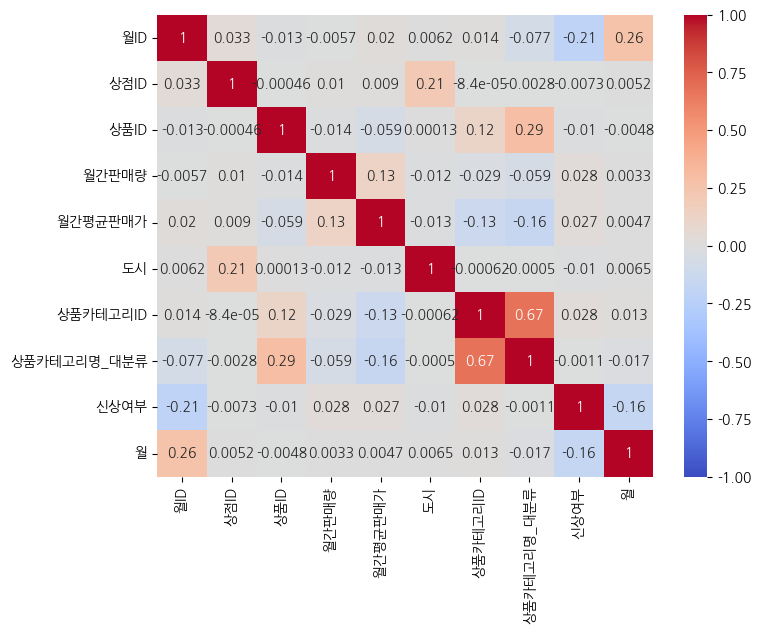

In [254]:
# 상관계수 행렬 및 히트맵
corr_matrix = df_all.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [255]:
# 상관계수 계산
from scipy import stats
corr, p_value = stats.pearsonr(df_all['상품카테고리명_대분류'], df_all['상품카테고리ID'])
print(f"상관계수: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

# 해석
alpha = 0.05
if p_value < alpha:
    print(f"p-value({p_value:.4f})가 {alpha}보다 작으므로, 상관관계가 통계적으로 유의합니다.")
else:
    print(f"p-value({p_value:.4f})가 {alpha}보다 크므로, 상관관계가 통계적으로 유의하지 않습니다.")

상관계수: 0.6726
p-value: 0.0000
p-value(0.0000)가 0.05보다 작으므로, 상관관계가 통계적으로 유의합니다.


## M. 컬럼 최종 삭제

In [167]:
# 대분류 삭제
df_all = df_all.drop(columns=['상품카테고리명_대분류'], axis=1)

# 3.데이터 분리
- 훈련 데이터: 2013년 1월부터 2015년 9월(월ID=32)까지 판매 내역
- 검증 데이터: 2015년 10월(월ID=33) 판매 내역
- 테스트 데이터: 2015년 11월(월ID=34) 판매 내역
- 시계열 데이터이므로 데이터 순서가 지켜져야 함

In [168]:
# 훈련 데이터
X_train = df_all[df_all['월ID'] < 33]
X_train = X_train.drop(['월간판매량'], axis=1)
y_train = df_all[df_all['월ID'] < 33]['월간판매량'].clip(0, 20)

# 검증 데이터
X_valid = df_all[df_all['월ID'] == 33]
X_valid = X_valid.drop(['월간판매량'], axis=1)
y_valid = df_all[df_all['월ID'] == 33]['월간판매량'].clip(0, 20)

# 테스트 데이터
X_test = df_all[df_all['월ID'] == 34]
X_test = X_test.drop(['월간판매량'], axis=1)

# 4.훈련 및 평가


## a. LightGBM
  1. [초기] 훈련: 2.39721, 검증: 2.08645, 제출 점수: 1.25083
  2. [2.J 추가 가공 후] 훈련: 0.689786, 검증: 0.727336, 제출 점수: 1.21693
  3. [대분류 삭제 후] 훈련: 0.694009, 검증: 0.725358, 제출 점수:

In [169]:
import lightgbm as lgb
from lightgbm import early_stopping

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

# 상품ID는 고윳값이 너무 많아서 제외함
# LightGBM은 고윳값 개수가 너무 많은 범주형 데이터는 수치형 데이터로 취급해야 성능이 더 잘 나온다고 함
cat_features = ['상점ID', '도시', '상품카테고리ID', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      callbacks=[early_stopping(stopping_rounds=30)],
                      categorical_feature=cat_features)

[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 10574731, number of used features: 8
[LightGBM] [Info] Start training from score 0.302540
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.694009	valid_1's rmse: 0.725358


In [170]:
# 예측
y_pred = lgb_model.predict(X_test).clip(0, 20)

In [172]:
# 제출 파일 생성
df_sample_submission['item_cnt_month'] = y_pred
df_sample_submission.to_csv('submission.csv', index=False)

In [173]:
# 변수 정리
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect()

0

# 5.추가 분석

## A. 추가 분석을 위한 학습용 데이터 준비
1. `df_monthly_train`: 월간판매량으로 정리된 데이터
  - `df_all`에는 전처리를 한 번에 하기 위해 테스트 데이터가 포함되어 있음
  - 분석 시 학습용 데이터로만 분석할 수 있도록 `df_monthly_train` 변수로 따로 분리
2. `df_daily_train`: 일간판매량으로 정리된 데이터
  - 추가 컬럼 미포함
3. `df_daily_train_ic_names`: `df_daily_train`에 상품명, 상품카테고리명이 포함된 데이터

In [256]:
# (1) df_monthly_train 준비
# 학습용 데이터만 따로 분리 - 테스트 데이터는 구분을 위해 '월ID'를 34로 설정해놓은 상태이며, 이를 이용하여 분리
df_monthly_train = df_all[df_all['월ID'] < 34]

# 다운캐스팅
df_monthly_train = downcast(df_monthly_train)

# 결과 확인
df_monthly_train.tail(3)

34.1% 압축됨


,월ID,상점ID,상품ID,월간판매량,월간평균판매가,도시,상품카테고리ID,상품카테고리명_대분류,신상여부,월
10812812,33,21,7640,0,0.00,3,64,9,1,9
10812813,33,21,7632,0,0.00,3,64,9,0,9
10812814,33,21,7440,0,0.00,3,57,11,0,9


In [257]:
# (2) df_daily_train 준비
# 4개로 분리된 데이터를 하나로 요약해서 보기 위해 임시로 합침
df_daily_train = df_sales_train.merge(df_shops, on='상점ID', how='left')
df_daily_train = df_daily_train.merge(df_items, on='상품ID', how='left')
df_daily_train = df_daily_train.merge(df_item_categories, on='상품카테고리ID', how='left')

# 일간매출 컬럼 추가
df_daily_train['일간매출'] = df_daily_train['판매가'] * df_daily_train['일간판매량']

# 월 컬럼 추가
df_daily_train['월'] = df_daily_train['월ID'].apply(lambda x: x % 12)

# 첫 판매월 삭제
df_daily_train = df_daily_train.drop(columns=['첫판매월'], axis=1)

# 다운캐스팅
df_daily_train = downcast(df_daily_train)

# 변수 정리
# del df_sales_train, df_shops, df_items, df_item_categories
# gc.collect()

# 결과 확인
df_daily_train.head(3)

12.7% 압축됨


,날짜,월ID,상점ID,상품ID,판매가,일간판매량,도시,상품카테고리ID,상품카테고리명_대분류,일간매출,월
0,02.01.2013,0,59,22154,999.00,1,야로슬라블,37,영화,999.00,0
1,03.01.2013,0,25,2552,899.00,1,모스크바,58,음악,899.00,0
2,06.01.2013,0,25,2554,1709.05,1,모스크바,58,음악,1709.05,0


In [258]:
# (3) df_daily_train_ic_names 준비
category_ko = pd.read_csv(data_path + 'category_ko.csv')
item_ko = pd.read_csv(data_path + 'item_ko.csv')
shops_ko = pd.read_csv(data_path + 'shops_translated.csv')

df_daily_train_ic_names = df_daily_train.merge(category_ko, on='상품카테고리ID', how='left')
df_daily_train_ic_names = df_daily_train_ic_names.merge(item_ko, on='상품ID', how='left')
df_daily_train_ic_names = df_daily_train_ic_names.merge(shops_ko, left_on='상점ID',
                                                        right_on='shop_id', how='left')

# '년도' 컬럼 추가
df_daily_train_ic_names['날짜'] = pd.to_datetime(df_daily_train_ic_names['날짜'], format='%d.%m.%Y')
df_daily_train_ic_names['년도'] = df_daily_train_ic_names['날짜'].dt.year

# shop_id 컬럼 삭제
df_daily_train_ic_names = df_daily_train_ic_names.drop(columns=['shop_id'], axis=1)

# 컬럼명 변경
df_daily_train_ic_names = df_daily_train_ic_names.rename(columns={'shop_name': '상점명'})

# 결과 확인
df_daily_train_ic_names.head(3)

,날짜,월ID,상점ID,상품ID,판매가,일간판매량,도시,상품카테고리ID,상품카테고리명_대분류,일간매출,월,상품카테고리명,상품명,상점명,년도
0,2013-01-02,0,59,22154,999.00,1,야로슬라블,37,영화,999.00,0,영화 - 블루레이,현상 2012 (BD),"야로슬라블, ""알타이르"" 쇼핑센터",2013
1,2013-01-03,0,25,2552,899.00,1,모스크바,58,음악,899.00,0,음악 - 바이닐,딥 퍼플 더 하우스 오브 블루 라이트 LP,"모스크바, ""아트리움"" 쇼핑몰",2013
2,2013-01-06,0,25,2554,1709.05,1,모스크바,58,음악,1709.05,0,음악 - 바이닐,딥 퍼플 우리가 LP라고 생각하는 사람은 누구일까요?,"모스크바, ""아트리움"" 쇼핑몰",2013


## B. 향후 판매량/매출 예측

### a. 향후 월간판매량 예측
- 시간이 지날수록 우하향하는 모습을 보여주고 있음

In [ ]:
# 데이터 준비
df_prophet = df_daily_train.groupby(['월ID'])['일간판매량'].sum() # 월별 판매량 계산
df_prophet.index = pd.date_range(start = '2013-01-01', end='2015-10-01', freq = 'MS') # 날짜 형태로 변환

df_prophet = df_prophet.reset_index() # 인덱스에 들어 있는 날짜 부분을 컬럼으로 빼기
df_prophet.columns = ['ds', 'y'] # 컬럼 이름 변경

# 결과 확인
df_prophet.head()

,ds,y
0,2013-01-01,131849
1,2013-02-01,128382
2,2013-03-01,147438
3,2013-04-01,107439
4,2013-05-01,107147


In [ ]:
# 학습
from prophet import Prophet

model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2cke3en5/5o0gzi_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2cke3en5/bt_2h9xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87495', 'data', 'file=/tmp/tmp2cke3en5/5o0gzi_s.json', 'init=/tmp/tmp2cke3en5/bt_2h9xn.json', 'output', 'file=/tmp/tmp2cke3en5/prophet_modelaps4tviq/prophet_model-20240722222423.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:24:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:24:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 예측
future = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future)

# 결과 확인
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,131849.55,131118.96,132637.93
1,2013-02-01,128949.78,128197.05,129731.97
2,2013-03-01,146765.46,145978.56,147567.80


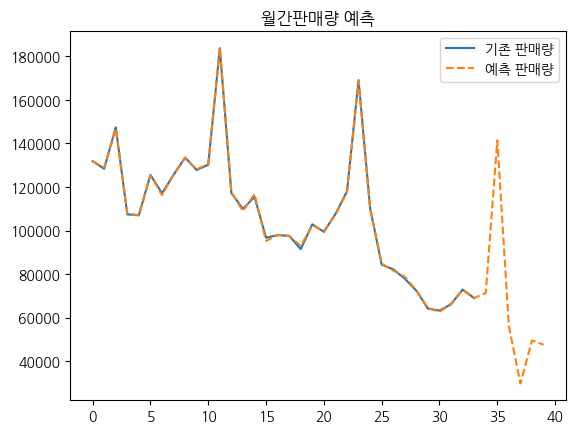

In [ ]:
# 예측 결과 시각화
plt.plot(list(df_prophet['y'].values), label='기존 판매량')
plt.plot(forecast['yhat'], ls='--', label='예측 판매량')
plt.legend(loc='best')
plt.title('월간판매량 예측')
plt.show()

### b. 향후 월간매출 예측

In [ ]:
# 데이터 준비
df_prophet = df_daily_train.groupby(['월ID'])['일간매출'].sum() # 월별 매출 계산
df_prophet.index = pd.date_range(start = '2013-01-01', end='2015-10-01', freq = 'MS') # 날짜 형태로 변환

df_prophet = df_prophet.reset_index() # 인덱스에 들어 있는 날짜 부분을 컬럼으로 빼기
df_prophet.columns = ['ds', 'y'] # 컬럼 이름 변경

# 결과 확인
df_prophet.head()

,ds,y
0,2013-01-01,92398943.72
1,2013-02-01,90964491.06
2,2013-03-01,105265370.13
3,2013-04-01,69457125.90
4,2013-05-01,65253166.76


In [ ]:
# 학습
from prophet import Prophet

model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2cke3en5/mgdk5dlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2cke3en5/pmtkmtl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14315', 'data', 'file=/tmp/tmp2cke3en5/mgdk5dlv.json', 'init=/tmp/tmp2cke3en5/pmtkmtl5.json', 'output', 'file=/tmp/tmp2cke3en5/prophet_model1fsm43iu/prophet_model-20240722222600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 예측
future = model.make_future_dataframe(periods=7, freq='MS')
forecast = model.predict(future)

# 결과 확인
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,92477255.20,91723015.68,93154689.23
1,2013-02-01,91888793.90,91153315.52,92586860.00
2,2013-03-01,104313280.44,103651075.83,105004283.91


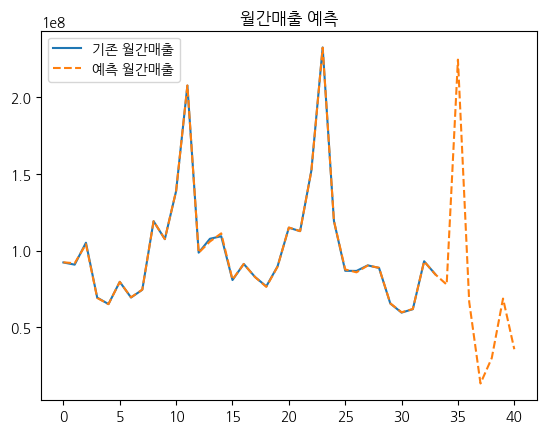

In [ ]:
# 예측 결과 시각화
plt.plot(list(df_prophet['y'].values), label='기존 월간매출')
plt.plot(forecast['yhat'], ls='--', label='예측 월간매출')
plt.legend(loc='best')
plt.title('월간매출 예측')
plt.show()

## C. 기준별 판매량/매출 분석

In [259]:
# 시각화 시간 단축을 위해 샘플 5% 추출
df_daily_train_samples = df_daily_train.sample(frac=0.05, random_state=0)
df_monthly_train_samples = df_monthly_train.sample(frac=0.05, random_state=0)

### a. 기간별 판매량/매출

<Axes: title={'center': '월간매출'}, xlabel='월ID', ylabel='월간매출'>

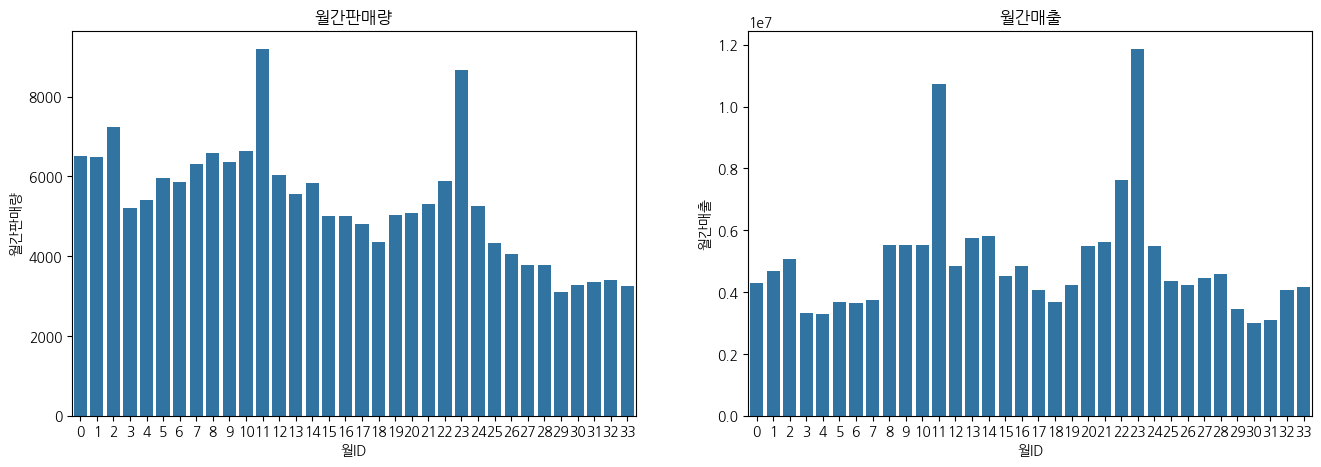

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# 월별 판매량 시각화
df = df_daily_train_samples.groupby(['월ID'])['일간판매량'].sum().reset_index()
df = df.rename(columns={'일간판매량': '월간판매량'})
axes[0].set_title('월간판매량')
sns.barplot(data=df, x='월ID', y='월간판매량', ax=axes[0])

# 월별 매출 시각화
df = df_daily_train_samples.groupby(['월ID'])['일간매출'].sum().reset_index()
df = df.rename(columns={'일간매출': '월간매출'})
axes[1].set_title('월간매출')
sns.barplot(data=df, x='월ID', y='월간매출', ax=axes[1])

### b. 계절별 판매량/매출
- 판매량: 연말, 연초에 높음
- 매출: 12월에 높음


<Axes: title={'center': 'Monthly sales'}, xlabel='월', ylabel='월간매출'>

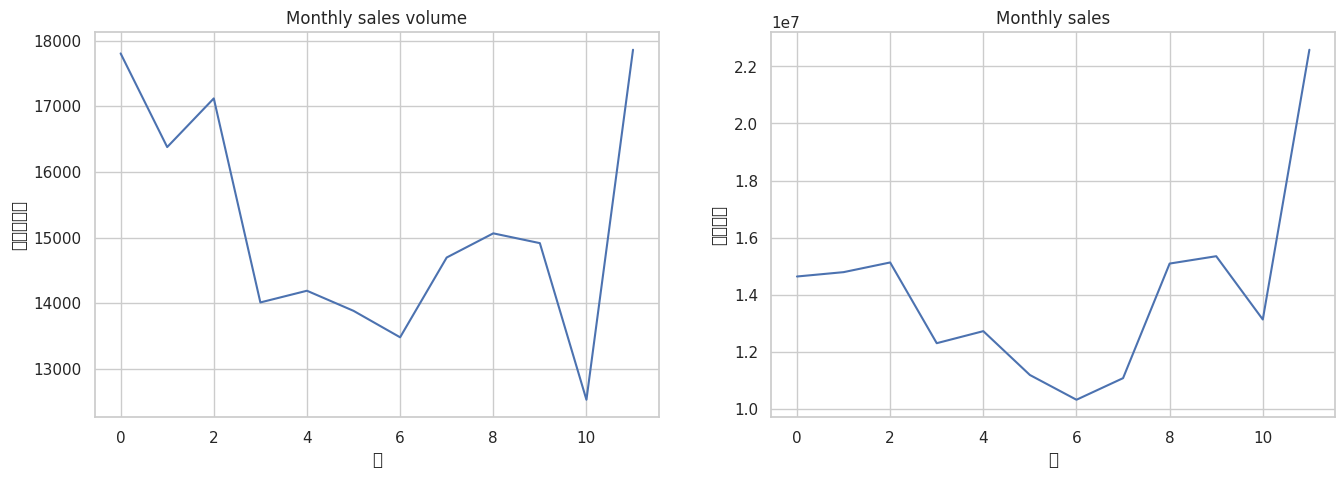

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# 월별 판매량 시각화
df = df_daily_train_samples.groupby(['월'])['일간판매량'].sum().reset_index()
df = df.rename(columns={'일간판매량': '월간판매량'})
axes[0].set_title('Monthly sales volume')
sns.lineplot(data=df, x='월', y='월간판매량', ax=axes[0])

# 월별 매출 시각화
df = df_daily_train_samples.groupby(['월'])['일간매출'].sum().reset_index()
df = df.rename(columns={'일간매출': '월간매출'})
axes[1].set_title('Monthly sales')
sns.lineplot(data=df, x='월', y='월간매출', ax=axes[1])

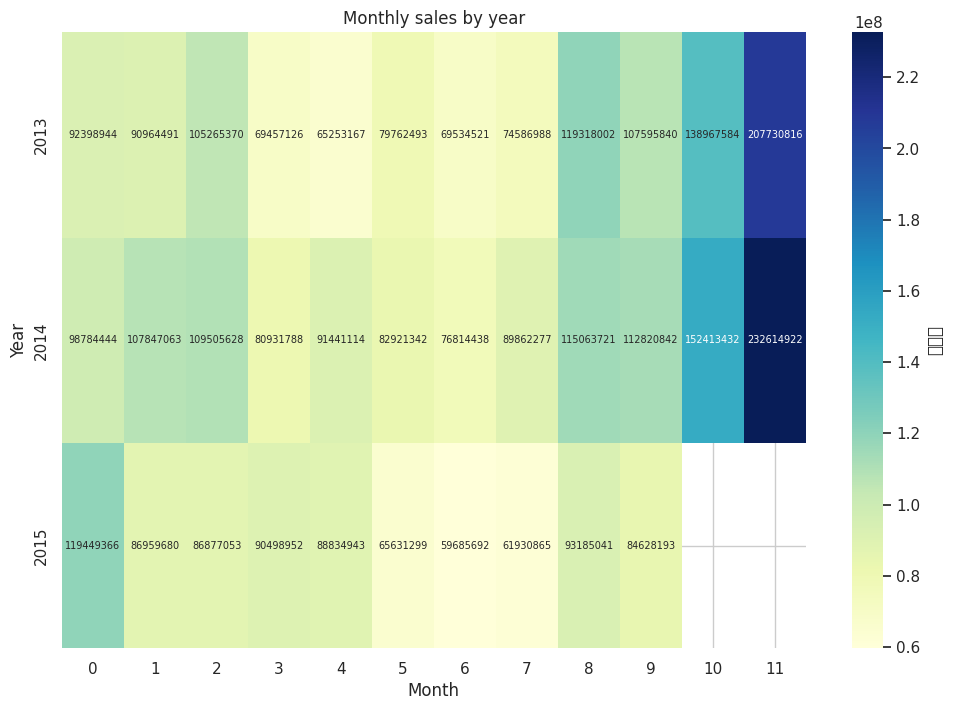

In [ ]:
# 연도 x 월별 매출 계산 (일매출의 합)
연도월별_매출 = df_daily_train_ic_names.groupby(['년도', '월'])['일간매출'].sum().reset_index()

# 피벗 테이블 생성 (시각화를 위해)
매출_피벗 = 연도월별_매출.pivot(index='년도', columns='월', values='일간매출')

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(매출_피벗, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': '매출액'}, annot_kws={"size": 7})
plt.title('Monthly sales by year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

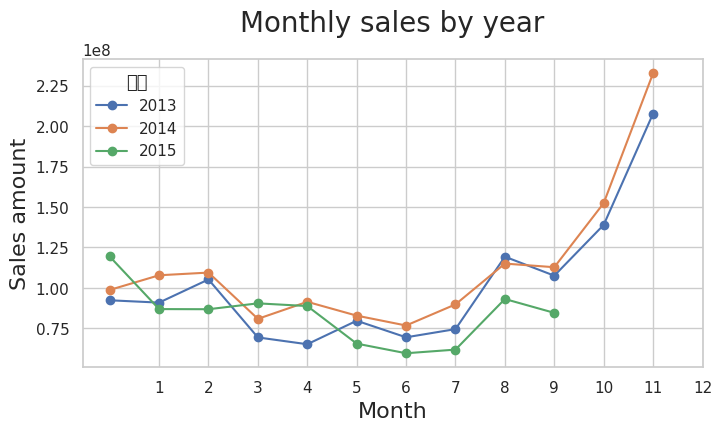

In [ ]:
# 위 동일 내용 꺾은선 그래프로 그려보기
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

# 각 연도의 매출 데이터를 각각 꺾은선 그래프로 추가
for year in 연도월별_매출['년도'].unique():
    yearly_data = 연도월별_매출[연도월별_매출['년도'] == year]
    plt.plot(yearly_data['월'], yearly_data['일간매출'], marker='o', label=str(year))

# 그래프 제목 및 레이블 설정
plt.title('Monthly sales by year', fontsize=20, pad=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Sales amount', fontsize=16)

# 범례 추가
plt.legend(title='년도', title_fontsize='13', fontsize='11')

# X축과 Y축 레이블을 더 보기 좋게 설정
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### c. 연도별 판매량/매출

- 1~10월 매출 비교
- 15년 6월부터 판매 부진
- 매출이 어디서 빠지는지 추가 확인 필요

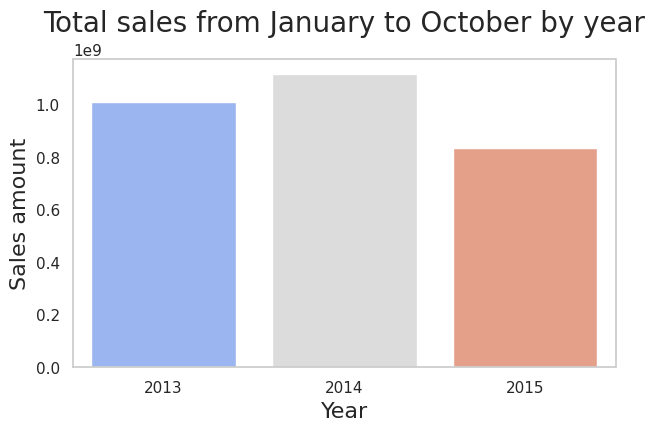

In [ ]:
# 3. 1월부터 10월까지의 데이터만 필터링
filtered_df = df_daily_train_ic_names[df_daily_train_ic_names['월'] <= 10]

# 4. 연도별 1월~10월 매출 합계 계산
연도별_매출합 = filtered_df.groupby('년도')['일간매출'].sum().reset_index()

# 5. 시각화
plt.figure(figsize=(7, 4))
sns.set(style="whitegrid")

# 막대그래프 그리기
sns.barplot(x='년도', y='일간매출', data=연도별_매출합, palette='coolwarm')

# 그래프 제목 및 레이블 설정
plt.title('Total sales from January to October by year', fontsize=20, pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Sales amount', fontsize=16)

# 범례 제거
plt.legend().set_visible(False)

# 그리드 추가
plt.grid(axis='y')

plt.show()

### e. 상품 대분류별 판매량/매출
- 판매량: 게임, 영화순으로 판매량이 높음
- 매출: 게임이 월등히 높음

<Axes: title={'center': '대분류별 매출'}, xlabel='상품카테고리명_대분류', ylabel='일간매출'>

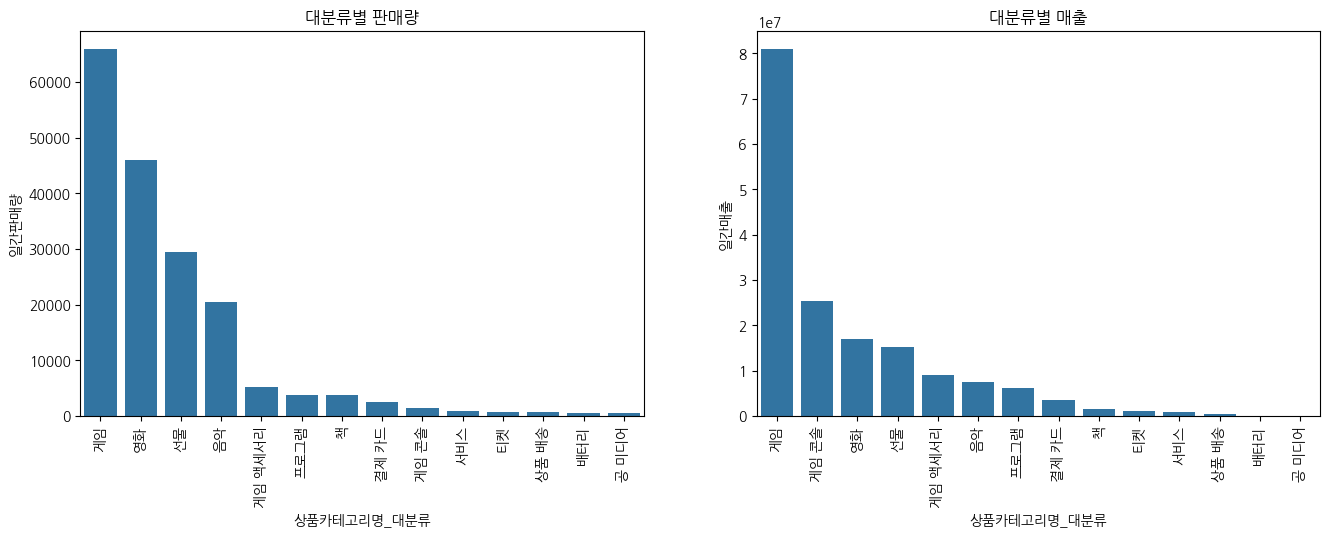

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# 대분류별 판매량 시각화
df = df_daily_train_samples.groupby(['상품카테고리명_대분류'])['일간판매량'].sum().reset_index()
df = df.sort_values(by='일간판매량', ascending=False)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_title('대분류별 판매량')
sns.barplot(data=df, x='상품카테고리명_대분류', y='일간판매량', ax=axes[0])

# 대분류별 매출 시각화
df = df_daily_train_samples.groupby(['상품카테고리명_대분류'])['일간매출'].sum().reset_index()
df = df.sort_values(by='일간매출', ascending=False)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_title('대분류별 매출')
sns.barplot(data=df, x='상품카테고리명_대분류', y='일간매출', ax=axes[1])

#### i. 기간별 상품카테고리 대분류별 판매량

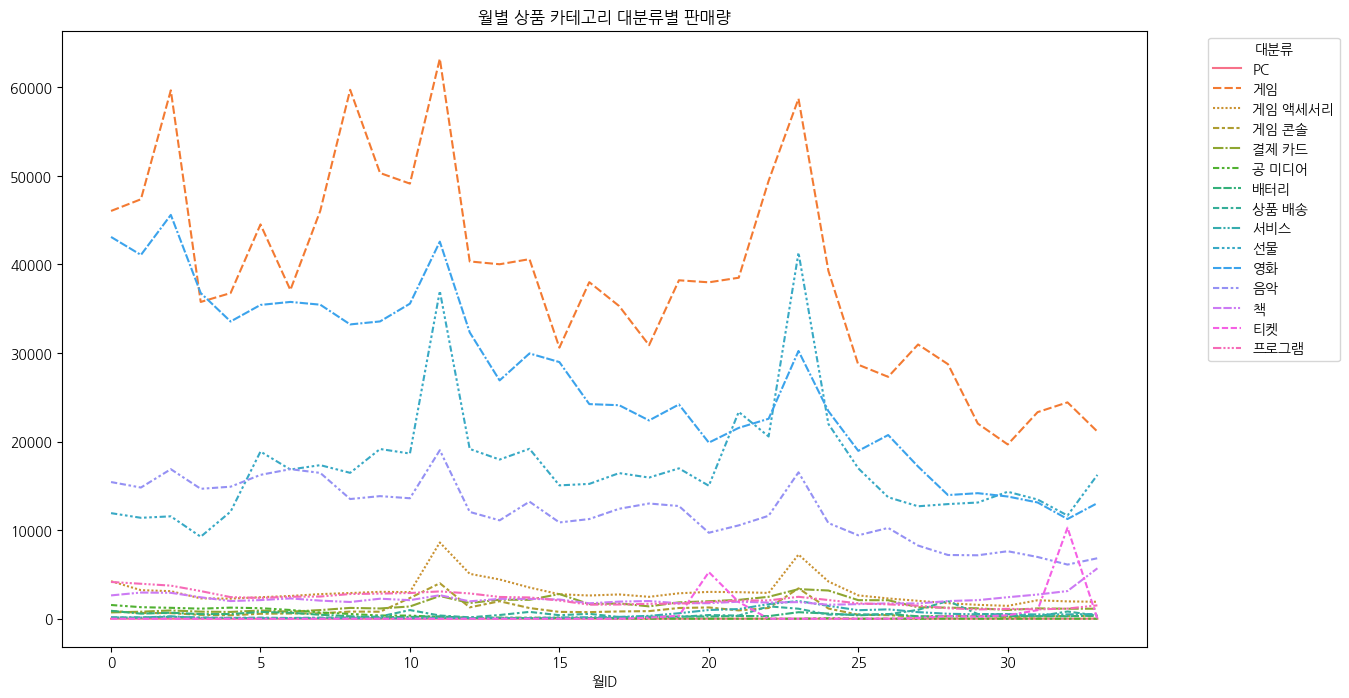

In [ ]:
# 기간별 상품 카테고리별 판매량
monthly_category_sales = df_daily_train.groupby(['월ID', '상품카테고리명_대분류'])['일간판매량'].sum().unstack().fillna(0)

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_category_sales)
plt.title('월별 상품 카테고리 대분류별 판매량')
plt.legend(title='대분류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### ii. 계절별 상품카테고리 대분류별 판매량

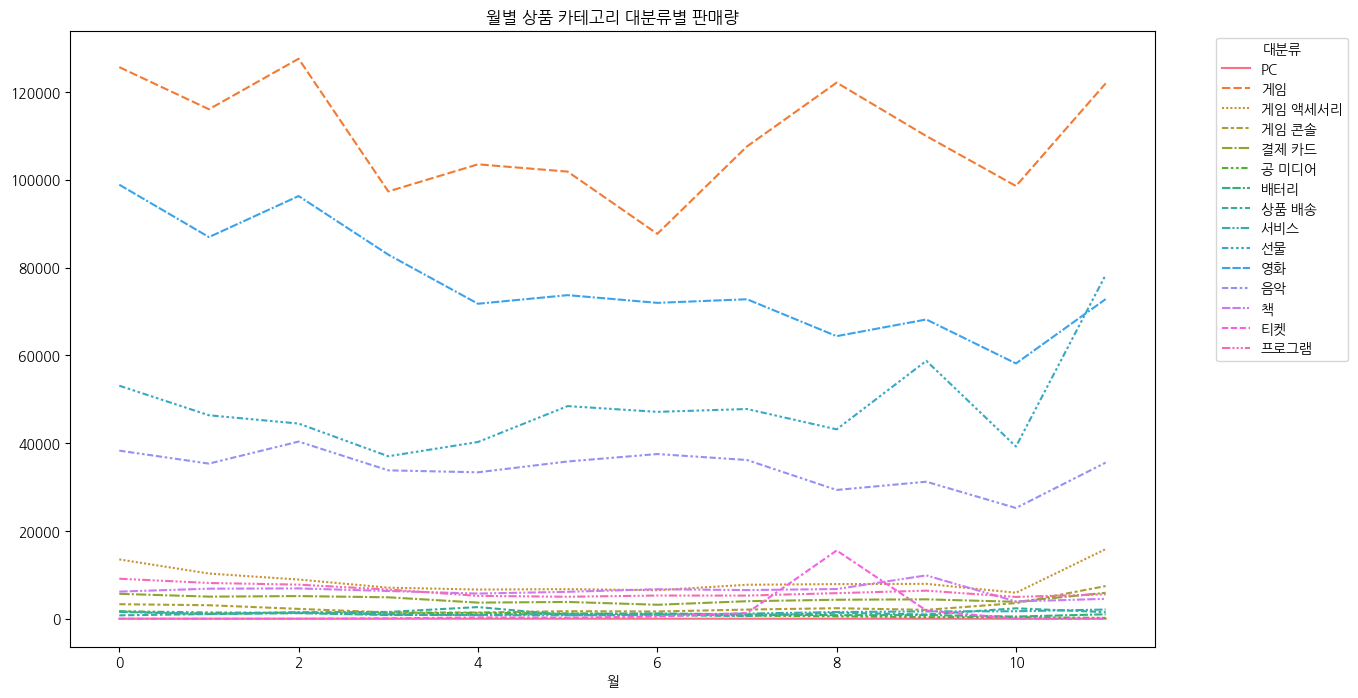

In [ ]:
# 계절별 상품 카테고리별 판매량
monthly_category_sales = df_daily_train.groupby(['월', '상품카테고리명_대분류'])['일간판매량'].sum().unstack().fillna(0)

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_category_sales)
plt.title('월별 상품 카테고리 대분류별 판매량')
plt.legend(title='대분류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### iii. 연도별, 상품 카테고리별 매출

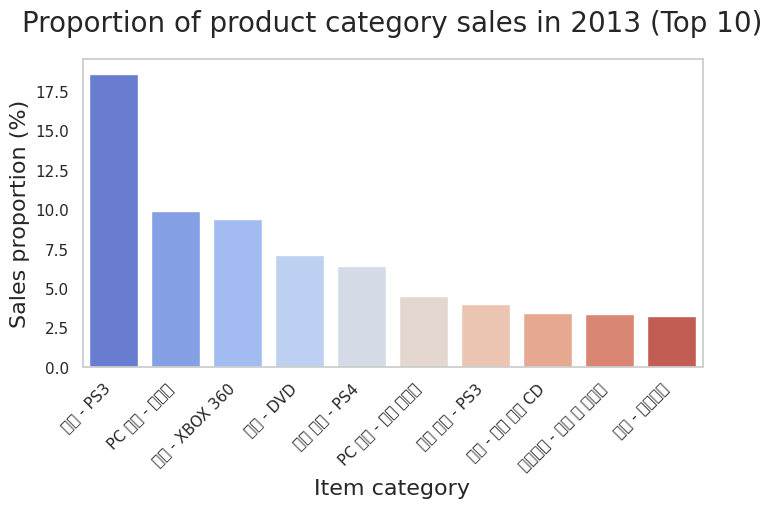

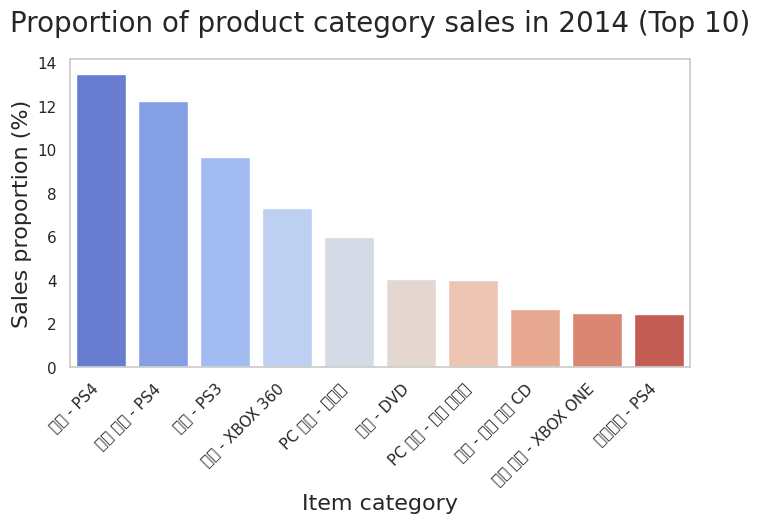

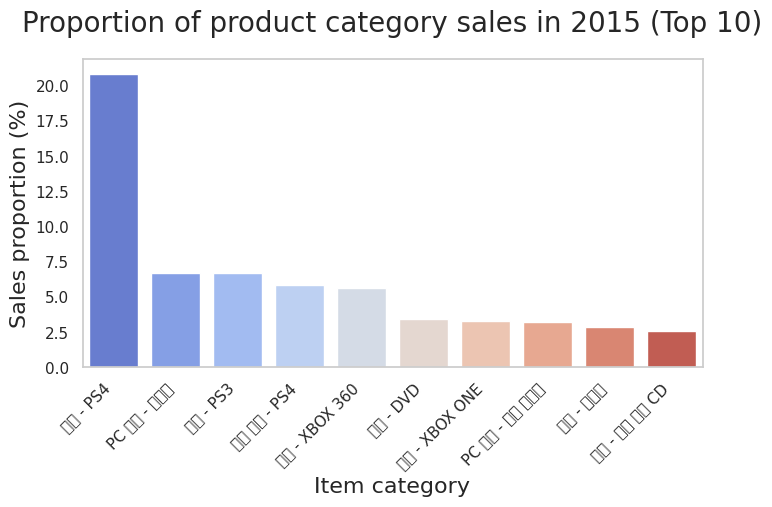

In [ ]:
# 연도별, 카테고리별 매출 합계 계산
연도별_카테고리_매출 = df_daily_train_ic_names.groupby(['년도', '상품카테고리명'])['일간매출'].sum().reset_index()

# 연도별 전체 매출 계산
연도별_전체_매출 = 연도별_카테고리_매출.groupby('년도')['일간매출'].sum().reset_index()
연도별_전체_매출.rename(columns={'일간매출': '전체_매출'}, inplace=True)

# 전체 매출과 결합
연도별_카테고리_매출 = pd.merge(연도별_카테고리_매출, 연도별_전체_매출, on='년도')
연도별_카테고리_매출['매출_비중'] = 연도별_카테고리_매출['일간매출'] / 연도별_카테고리_매출['전체_매출'] * 100

# 연도별 상위 10개 카테고리 추출 및 시각화
for year in 연도별_카테고리_매출['년도'].unique():
    plt.figure(figsize=(8, 4))
    sns.set(style="whitegrid")

    # 특정 연도의 데이터 필터링
    year_data = 연도별_카테고리_매출[연도별_카테고리_매출['년도'] == year]

    # 상위 10개 카테고리 추출
    top_categories = year_data.nlargest(10, '일간매출')

    # 막대그래프 그리기
    sns.barplot(x='상품카테고리명', y='매출_비중', data=top_categories, palette='coolwarm')

    # 그래프 제목 및 레이블 설정
    plt.title(f'Proportion of product category sales in {year} (Top 10)', fontsize=20, pad=20)
    plt.xlabel('Item category', fontsize=16)
    plt.ylabel('Sales proportion (%)', fontsize=16)

    # X축 레이블 회전
    plt.xticks(rotation=45, ha='right')

    # 그리드 추가
    plt.grid(axis='y')

    # 그래프 표시
    plt.show()

In [ ]:
# 2013 상위 10개 카테고리 추출
연도별_카테고리_매출[연도별_카테고리_매출['년도'] == 2013].nlargest(10, '일간매출')

,년도,상품카테고리명,일간매출,전체_매출,매출_비중
6,2013,게임 - PS3,227118991.08,1220835341.88,18.60
4,2013,PC 게임 - 표준판,120897376.09,1220835341.88,9.90
10,2013,게임 - XBOX 360,115163164.93,1220835341.88,9.43
45,2013,영화 - DVD,87089908.80,1220835341.88,7.13
14,2013,게임 콘솔 - PS4,78637447.00,1220835341.88,6.44
2,2013,PC 게임 - 추가 에디션,55697919.16,1220835341.88,4.56
13,2013,게임 콘솔 - PS3,49242883.71,1220835341.88,4.03
52,2013,음악 - 로컬 제작 CD,42521921.03,1220835341.88,3.48
66,2013,프로그램 - 가정 및 사무용,41617095.21,1220835341.88,3.41
46,2013,영화 - 블루레이,39498394.10,1220835341.88,3.24


In [ ]:
# 2014 상위 10개 카테고리 추출
연도별_카테고리_매출[연도별_카테고리_매출['년도'] == 2014].nlargest(10, '일간매출')

,년도,상품카테고리명,일간매출,전체_매출,매출_비중
75,2014,게임 - PS4,182215339.47,1351021011.55,13.49
84,2014,게임 콘솔 - PS4,165305648.81,1351021011.55,12.24
74,2014,게임 - PS3,130362285.67,1351021011.55,9.65
78,2014,게임 - XBOX 360,98464201.23,1351021011.55,7.29
73,2014,PC 게임 - 표준판,80942283.87,1351021011.55,5.99
117,2014,영화 - DVD,54585071.92,1351021011.55,4.04
71,2014,PC 게임 - 추가 에디션,53941909.94,1351021011.55,3.99
124,2014,음악 - 로컬 제작 CD,36264176.32,1351021011.55,2.68
88,2014,게임 콘솔 - XBOX ONE,33488788.31,1351021011.55,2.48
111,2014,액세서리 - PS4,32737140.40,1351021011.55,2.42


In [ ]:
# 2015 상위 10개 카테고리 추출
연도별_카테고리_매출[연도별_카테고리_매출['년도'] == 2015].nlargest(10, '일간매출')

,년도,상품카테고리명,일간매출,전체_매출,매출_비중
149,2015,게임 - PS4,174497232.22,837681085.14,20.83
146,2015,PC 게임 - 표준판,56119614.76,837681085.14,6.70
148,2015,게임 - PS3,56023658.06,837681085.14,6.69
158,2015,게임 콘솔 - PS4,49148613.67,837681085.14,5.87
152,2015,게임 - XBOX 360,47018610.85,837681085.14,5.61
189,2015,영화 - DVD,28450490.82,837681085.14,3.40
153,2015,게임 - XBOX ONE,27622853.71,837681085.14,3.30
144,2015,PC 게임 - 추가 에디션,26987928.20,837681085.14,3.22
180,2015,선물 - 피규어,24094290.61,837681085.14,2.88
196,2015,음악 - 로컬 제작 CD,21377103.27,837681085.14,2.55


### f. 도시별 판매량/매출
- 판매량/매출 모두 모스크바에서 월등히 높음

<Axes: title={'center': '도시별 매출'}, xlabel='도시', ylabel='일간매출'>

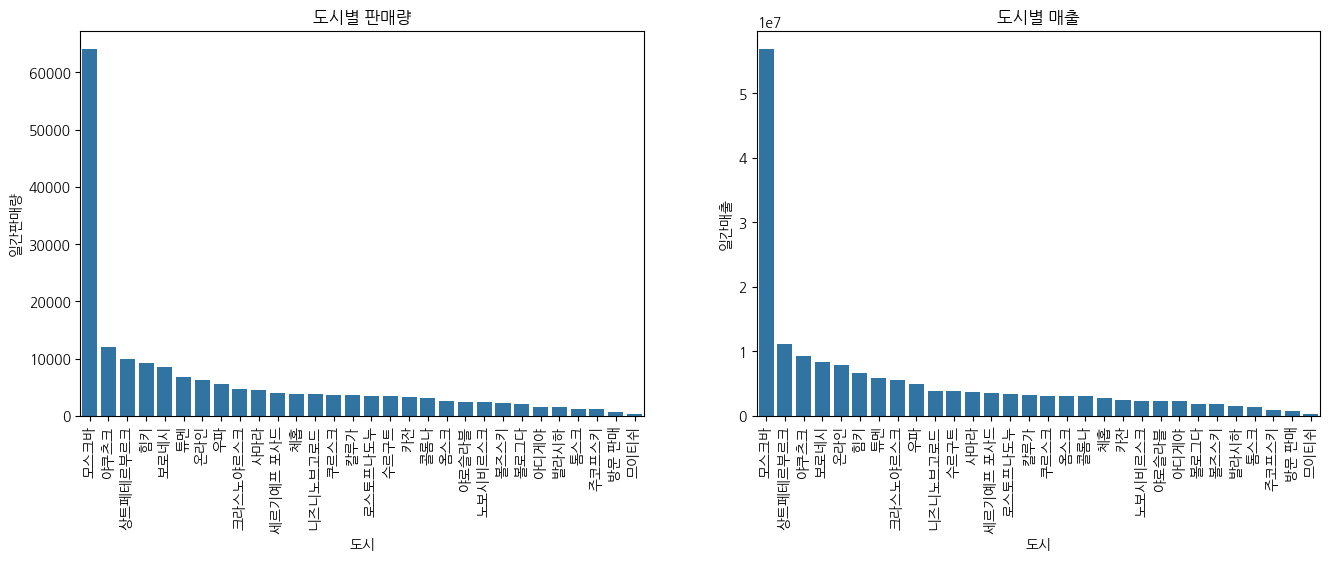

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# 도시별 판매량 시각화
df = df_daily_train_samples.groupby(['도시'])['일간판매량'].sum().reset_index()
df = df.sort_values(by='일간판매량', ascending=False)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_title('도시별 판매량')
sns.barplot(data=df, x='도시', y='일간판매량', ax=axes[0])

# 도시별 매출 시각화
df = df_daily_train_samples.groupby(['도시'])['일간매출'].sum().reset_index()
df = df.sort_values(by='일간매출', ascending=False)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_title('도시별 매출')
sns.barplot(data=df, x='도시', y='일간매출', ax=axes[1])

### g. 상점별 판매량/매출

<Axes: title={'center': '상점별 매출'}, xlabel='상점ID', ylabel='일간매출'>

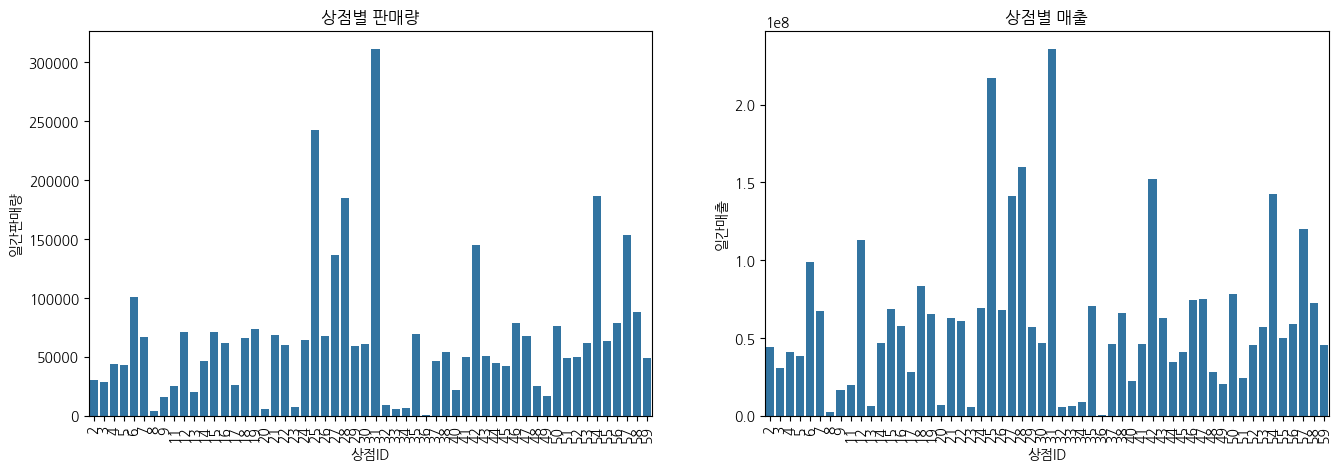

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

# 상점별 판매량 시각화
df = df_daily_train.groupby(['상점ID'])['일간판매량'].sum().reset_index()
df = df.sort_values(by='일간판매량', ascending=False)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_title('상점별 판매량')
sns.barplot(data=df, x='상점ID', y='일간판매량', ax=axes[0])

# 상점별 매출 시각화
df = df_daily_train.groupby(['상점ID'])['일간매출'].sum().reset_index()
df = df.sort_values(by='일간매출', ascending=False)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_title('상점별 매출')
sns.barplot(data=df, x='상점ID', y='일간매출', ax=axes[1])

### h. 신상 여부별 판매량
- 신상 판매량이 높음

<Axes: xlabel='신상여부', ylabel='월간판매량'>

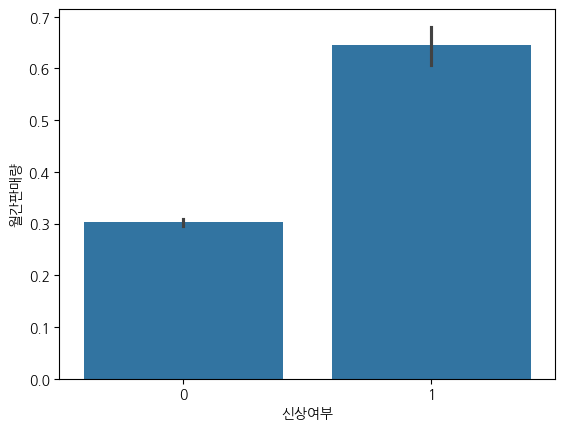

In [261]:
sns.barplot(data=df_monthly_train_samples, x='신상여부', y='월간판매량')

In [262]:
from scipy import stats

# 신상품과 기존 상품의 판매량 데이터 분리
new_product_sales = df_monthly_train[df_monthly_train['신상여부'] == True]['월간판매량']
existing_product_sales = df_monthly_train[df_monthly_train['신상여부'] == False]['월간판매량']

# t-검정 수행
t_stat, p_value = stats.ttest_ind(new_product_sales, existing_product_sales, nan_policy='omit')

print(f"t-Statistic: {t_stat}")
print(f"p-Value: {p_value}")

# 유의 수준 설정 (예: 0.05)
alpha = 0.05

# p-값이 유의 수준보다 작으면 귀무 가설 기각
if p_value < alpha:
    print("귀무 가설을 기각합니다. 신상품의 판매량이 기존 상품의 판매량보다 유의미하게 높습니다.")
else:
    print("귀무 가설을 기각하지 않습니다. 신상품의 판매량이 기존 상품의 판매량과 유의미하게 다르지 않습니다.")

t-Statistic: 91.22155160623507
p-Value: 0.0
귀무 가설을 기각합니다. 신상품의 판매량이 기존 상품의 판매량보다 유의미하게 높습니다.


## D. 가격과 판매량의 관계

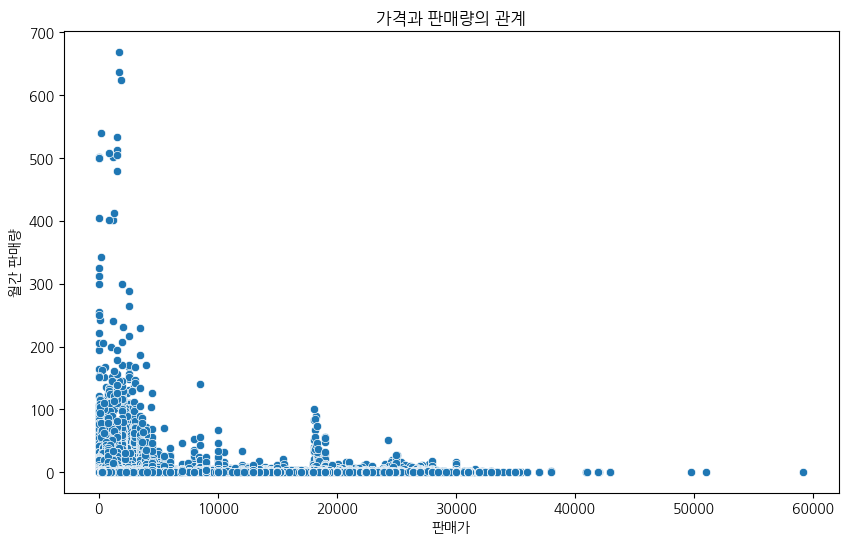

In [ ]:
# 가격과 판매량의 상관관계
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_daily_train, x='판매가', y='일간판매량')
plt.title('가격과 판매량의 관계')
plt.xlabel('판매가')
plt.ylabel('월간 판매량')
plt.show()

## E. 매출 변화 분석

### a. 상품카테고리별 매출 하락율

In [ ]:
# 2013, 2014, 2015년 1~10월 데이터만 필터링
filtered_df = df_daily_train_ic_names[
    (df_daily_train_ic_names['년도'].isin([2013, 2014, 2015])) &
    (df_daily_train_ic_names['월'].between(1, 10))
]

# 연도와 월별로 평균 매출 계산
average_sales = filtered_df.groupby(['년도', '상품카테고리명'])['일간매출'].mean().reset_index()

# 2015년의 데이터와 2013, 2014년의 데이터로 나누기
sales_2015 = average_sales[average_sales['년도'] == 2015]
sales_2013_2014 = average_sales[average_sales['년도'].isin([2013, 2014])]

# 2013, 2014년의 평균 매출을 계산
average_sales_2013_2014 = sales_2013_2014.groupby('상품카테고리명')['일간매출'].mean().reset_index()
average_sales_2013_2014.rename(columns={'일간매출': '평균_2013_2014'}, inplace=True)

# 2015년 데이터와 병합
sales_2015 = pd.merge(sales_2015, average_sales_2013_2014, on='상품카테고리명')

# 매출 하락률 계산
sales_2015['하락률'] = (sales_2015['평균_2013_2014'] - sales_2015['일간매출']) / sales_2015['평균_2013_2014'] * 100

# 하락률 기준으로 상위 10개 카테고리 추출
top_10_decline_categories = sales_2015.nlargest(10, '하락률')

# 결과 출력
print(top_10_decline_categories[['상품카테고리명', '평균_2013_2014', '일간매출', '하락률']])

               상품카테고리명  평균_2013_2014     일간매출   하락률
4             게임 - PS2        510.04    28.00 94.51
13         게임 콘솔 - PS4     208918.78 30275.20 85.51
36          액세서리 - PSP        462.17   126.30 72.67
17          게임 콘솔 - 기타       2410.40  1290.00 46.48
6             게임 - PS4       8293.69  5123.40 38.23
24  선물 - 가방, 앨범, 마우스패드         30.48    21.46 29.59
37       액세서리 - PSVita        872.87   617.27 29.28
5             게임 - PS3       2056.28  1570.04 23.65
23               상품 배송       3273.02  2572.30 21.41
55      책 - 오디오북 (디지털)        169.62   135.96 19.84


In [ ]:
top_10_decline_categories

,년도,상품카테고리명,일간매출,평균_2013_2014,하락률
4,2015,게임 - PS2,28.00,510.04,94.51
13,2015,게임 콘솔 - PS4,30275.20,208918.78,85.51
36,2015,액세서리 - PSP,126.30,462.17,72.67
17,2015,게임 콘솔 - 기타,1290.00,2410.40,46.48
6,2015,게임 - PS4,5123.40,8293.69,38.23
24,2015,"선물 - 가방, 앨범, 마우스패드",21.46,30.48,29.59
37,2015,액세서리 - PSVita,617.27,872.87,29.28
5,2015,게임 - PS3,1570.04,2056.28,23.65
23,2015,상품 배송,2572.30,3273.02,21.41
55,2015,책 - 오디오북 (디지털),135.96,169.62,19.84


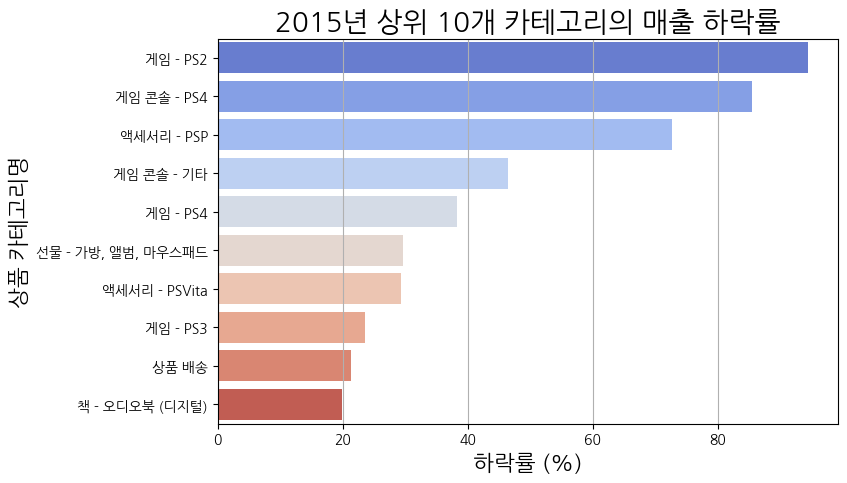

In [ ]:
# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='하락률', y='상품카테고리명', data=top_10_decline_categories, palette='coolwarm')

# 그래프 제목 및 레이블 설정
plt.title('2015년 상위 10개 카테고리의 매출 하락률', fontsize=20)
plt.xlabel('하락률 (%)', fontsize=16)
plt.ylabel('상품 카테고리명', fontsize=16)

# 그리드 추가
plt.grid(axis='x')

# 그래프 표시
plt.show()

### b. 상품카테고리별 매출 상승률

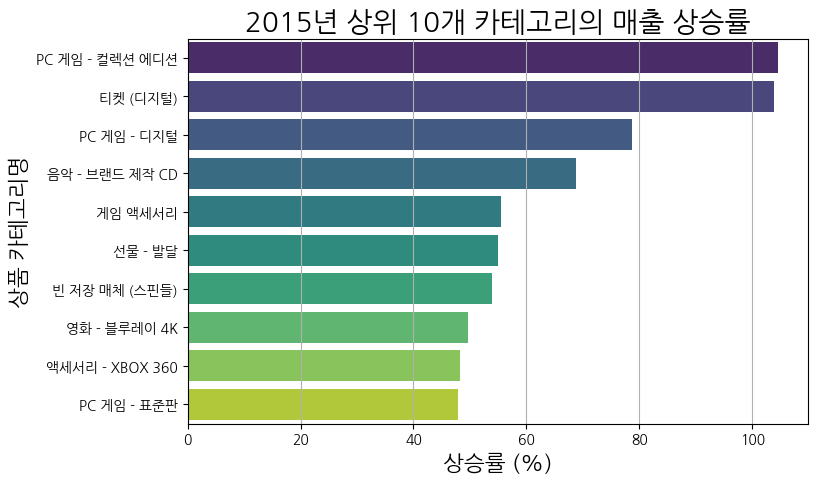

In [ ]:
# 매출 상승률 계산
sales_2015['상승률'] = (sales_2015['일간매출'] - sales_2015['평균_2013_2014']) / sales_2015['평균_2013_2014'] * 100

# 상승률 기준으로 상위 10개 카테고리 추출
top_10_increase_categories = sales_2015.nlargest(10, '상승률')

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='상승률', y='상품카테고리명', data=top_10_increase_categories, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('2015년 상위 10개 카테고리의 매출 상승률', fontsize=20)
plt.xlabel('상승률 (%)', fontsize=16)
plt.ylabel('상품 카테고리명', fontsize=16)

# 그리드 추가
plt.grid(axis='x')

# 그래프 표시
plt.show()

In [ ]:
top_10_increase_categories

,년도,상품카테고리명,일간매출,평균_2013_2014,하락률,상승률
2,2015,PC 게임 - 컬렉션 에디션,9991.79,4884.92,-104.54,104.54
56,2015,티켓 (디지털),16438.26,8062.90,-103.88,103.88
0,2015,PC 게임 - 디지털,1467.81,821.36,-78.71,78.71
50,2015,음악 - 브랜드 제작 CD,1686.99,999.15,-68.84,68.84
11,2015,게임 액세서리,1225.02,787.77,-55.50,55.50
28,2015,선물 - 발달,1051.39,678.66,-54.92,54.92
22,2015,빈 저장 매체 (스핀들),350.00,227.35,-53.95,53.95
44,2015,영화 - 블루레이 4K,1032.33,689.78,-49.66,49.66
38,2015,액세서리 - XBOX 360,2782.63,1876.73,-48.27,48.27
3,2015,PC 게임 - 표준판,1030.44,696.84,-47.87,47.87


In [ ]:
sales_2015.nlargest(30, '상승률')

,년도,상품카테고리명,일간매출,평균_2013_2014,하락률,상승률
2,2015,PC 게임 - 컬렉션 에디션,9991.79,4884.92,-104.54,104.54
56,2015,티켓 (디지털),16438.26,8062.90,-103.88,103.88
0,2015,PC 게임 - 디지털,1467.81,821.36,-78.71,78.71
50,2015,음악 - 브랜드 제작 CD,1686.99,999.15,-68.84,68.84
11,2015,게임 액세서리,1225.02,787.77,-55.50,55.50
28,2015,선물 - 발달,1051.39,678.66,-54.92,54.92
22,2015,빈 저장 매체 (스핀들),350.00,227.35,-53.95,53.95
44,2015,영화 - 블루레이 4K,1032.33,689.78,-49.66,49.66
38,2015,액세서리 - XBOX 360,2782.63,1876.73,-48.27,48.27
3,2015,PC 게임 - 표준판,1030.44,696.84,-47.87,47.87


## F. 게임 매출 분석

### a. 연도별 플레이스테이션 매출

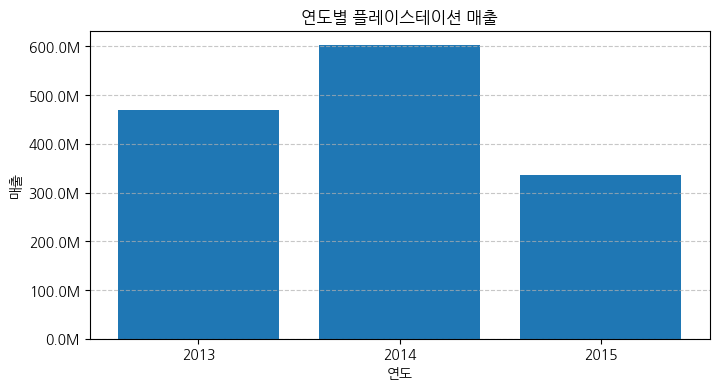

In [ ]:
from matplotlib.ticker import FuncFormatter

# '상품카테고리명'에 'PS'가 포함된 데이터 필터링
ps_filtered_df = df_daily_train_ic_names[df_daily_train_ic_names['상품카테고리명'].str.contains('PS', na=False)]

# 년도별 일매출 총합 계산
ps_yearly_sales = ps_filtered_df.groupby('년도')['일간매출'].sum().reset_index()

# y축 단위 변경 함수 정의
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(billions)

# 시각화
plt.figure(figsize=(8, 4))
plt.bar(ps_yearly_sales['년도'], ps_yearly_sales['일간매출'])
plt.xlabel('연도')
plt.ylabel('매출')
plt.title('연도별 플레이스테이션 매출')
plt.xticks(ps_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### b. 연도별 플레이스테이션 매출 비중

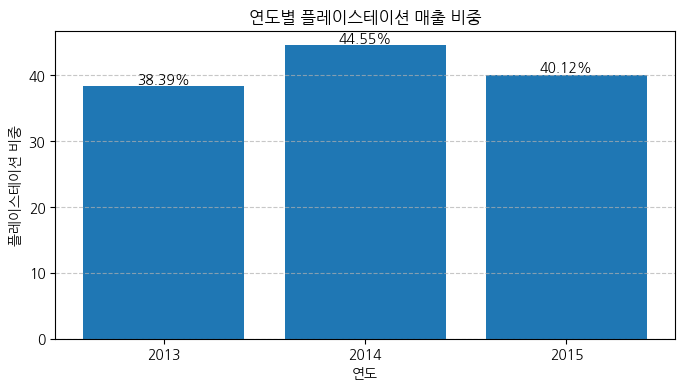

In [ ]:
# 년도별 전체 일간매출 총합 계산
total_yearly_sales = df_daily_train_ic_names.groupby('년도')['일간매출'].sum().reset_index()

# PS 관련 매출이 전체 매출에서 차지하는 비중 계산
merged_df = pd.merge(ps_yearly_sales, total_yearly_sales, on='년도', suffixes=('_PS', '_Total'))
merged_df['비중'] = merged_df['일간매출_PS'] / merged_df['일간매출_Total'] * 100

# 시각화
plt.figure(figsize=(8, 4))
plt.bar(merged_df['년도'], merged_df['비중'])
plt.xlabel('연도')
plt.ylabel('플레이스테이션 비중')
plt.title('연도별 플레이스테이션 매출 비중')
plt.xticks(merged_df['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 각 지점에 퍼센트 값 표시
for i in range(len(merged_df)):
    plt.text(merged_df['년도'][i], merged_df['비중'][i], f'{merged_df["비중"][i]:.2f}%',
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

### c. 연도별 게임 매출

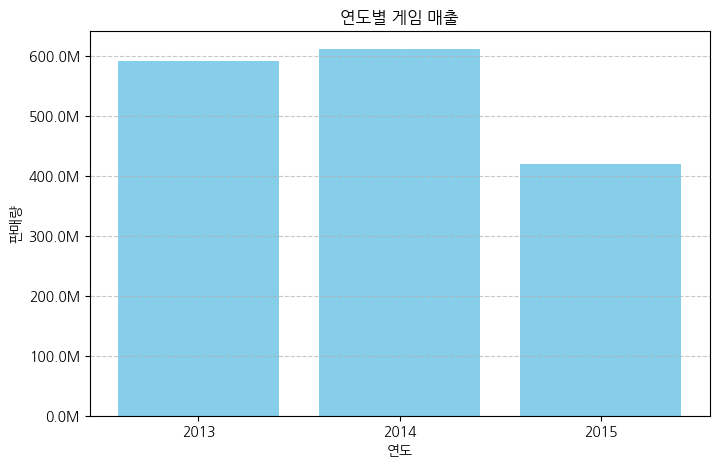

In [ ]:
from matplotlib.ticker import FuncFormatter

# 대분류가 게임인 데이터 필터링
ps_filtered_df = df_daily_train_ic_names[df_daily_train_ic_names['상품카테고리명_대분류'] == '게임']

# 년도별 일매출 총합 계산
ps_yearly_sales = ps_filtered_df.groupby('년도')['일간매출'].sum().reset_index()

# y축 단위 변경 함수 정의
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(billions)

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(ps_yearly_sales['년도'], ps_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 게임 매출')
plt.xticks(ps_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### d. 연도별 게임 매출 비중

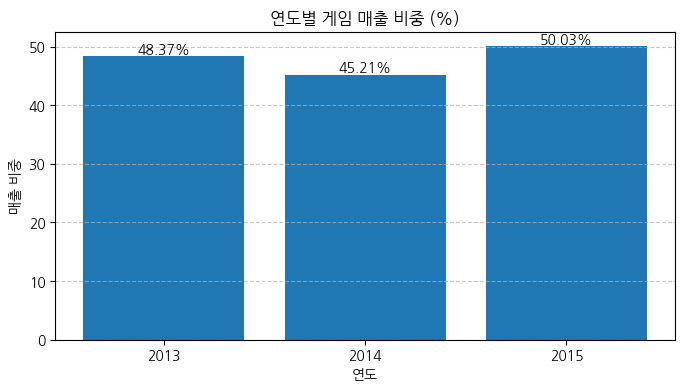

In [ ]:
# 년도별 전체 일간매출 총합 계산
total_yearly_sales = df_daily_train_ic_names.groupby('년도')['일간매출'].sum().reset_index()

# PS 관련 매출이 전체 매출에서 차지하는 비중 계산
merged_df = pd.merge(ps_yearly_sales, total_yearly_sales, on='년도', suffixes=('_PS', '_Total'))
merged_df['비중'] = merged_df['일간매출_PS'] / merged_df['일간매출_Total'] * 100

# 시각화
plt.figure(figsize=(8, 4))
plt.bar(merged_df['년도'], merged_df['비중'])
plt.xlabel('연도')
plt.ylabel('매출 비중')
plt.title('연도별 게임 매출 비중 (%)')
plt.xticks(merged_df['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 각 지점에 퍼센트 값 표시
for i in range(len(merged_df)):
    plt.text(merged_df['년도'][i], merged_df['비중'][i], f'{merged_df["비중"][i]:.2f}%',
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

## G. 소프트웨어 프로그램 상품 분석

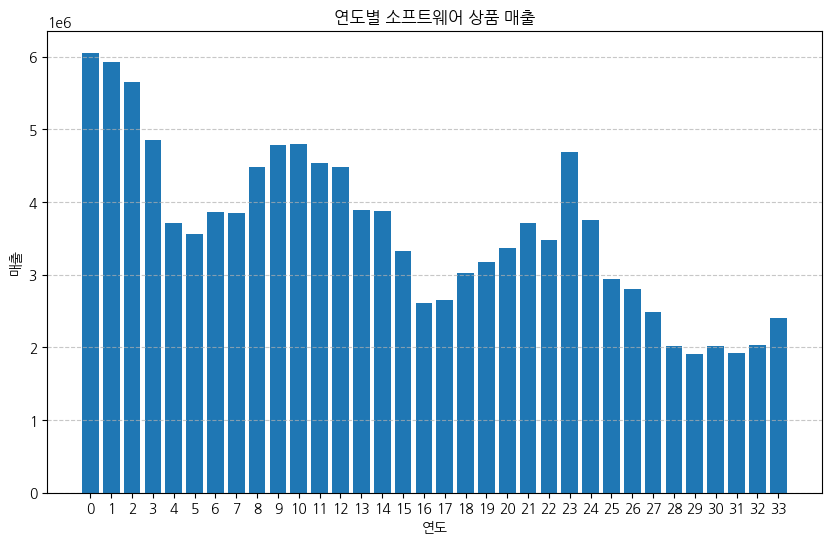

In [ ]:
# '상품카테고리ID'가 73에서 78 사이인 데이터 필터링
sw_filtered_df = df_daily_train_ic_names[df_daily_train_ic_names['상품카테고리ID'].between(73, 78)]

# 년도별 필터링된 데이터의 일간매출 총합 계산
sw_filtered_yearly_sales = sw_filtered_df.groupby('월ID')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(sw_filtered_yearly_sales['월ID'], sw_filtered_yearly_sales['일간매출'])
plt.xlabel('연도')
plt.ylabel('매출')
plt.title('연도별 소프트웨어 상품 매출')
plt.xticks(sw_filtered_yearly_sales['월ID'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## H. 온오프라인 판매처 분석

### a. 연도별 온라인 판매량/매출

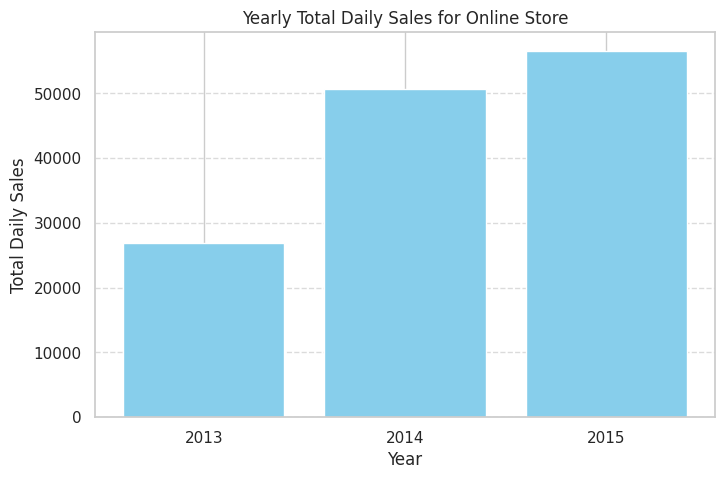

In [268]:
# '상점명'이 'online store'인 데이터 필터링
online_store_df = df_daily_train_ic_names[df_daily_train_ic_names['도시'] == '온라인']

# 년도별 'online store'의 일간판매량 총합 계산
online_store_yearly_sales = online_store_df.groupby('년도')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(online_store_yearly_sales['년도'], online_store_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total Daily Sales')
plt.title('Yearly Total Daily Sales for Online Store')
plt.xticks(online_store_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

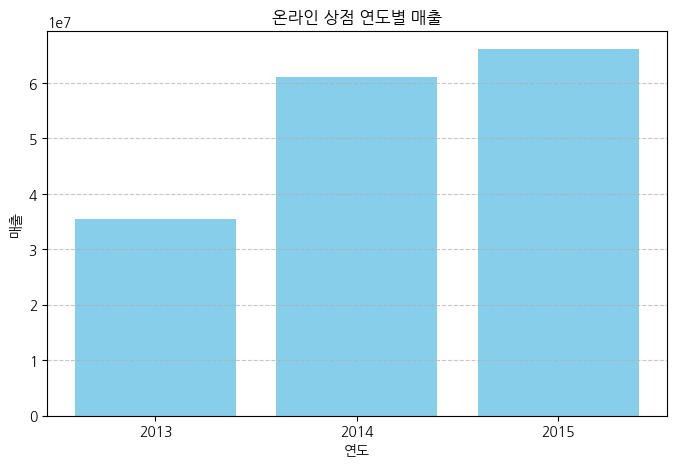

In [ ]:
# 온라인 상점 데이터 필터링
online_store_df = df_daily_train_ic_names[df_daily_train_ic_names['도시'] == '온라인']

# 년도별 온라인 상점의 일간매출 총합 계산
online_store_yearly_sales = online_store_df.groupby('년도')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(online_store_yearly_sales['년도'], online_store_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('매출')
plt.title('온라인 상점 연도별 매출')
plt.xticks(online_store_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### b. 기간별 온라인 매출

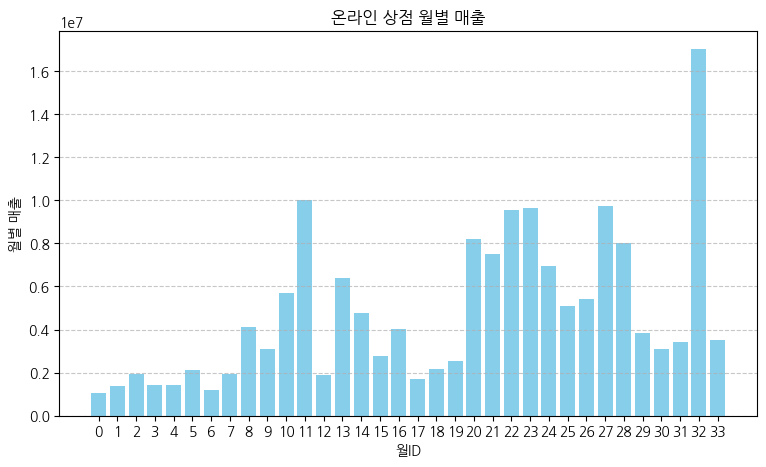

In [ ]:
# 온라인 상점의 월별 매출 총합 계산
online_store_monthly_sales = online_store_df.groupby('월ID')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(9, 5))
plt.bar(online_store_monthly_sales['월ID'], online_store_monthly_sales['일간매출'], color='skyblue')
plt.xlabel('월ID')
plt.ylabel('월별 매출')
plt.title('온라인 상점 월별 매출')
plt.xticks(online_store_monthly_sales['월ID'])  # x축에 월ID 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### c. 연도별 오프라인 판매량/매출

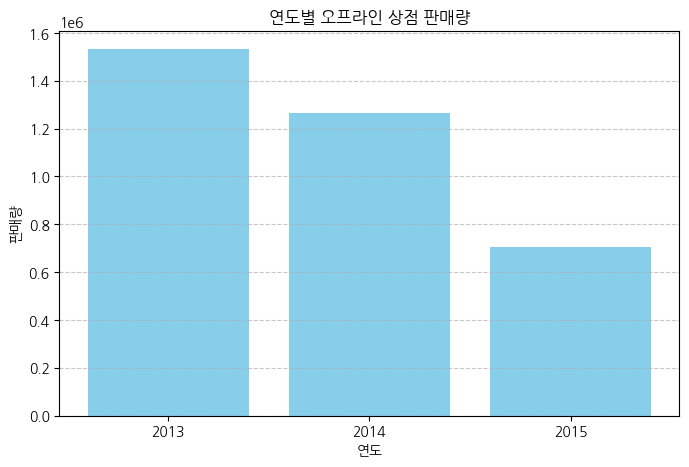

In [ ]:
# '상점명'이 'offline store'인 데이터 필터링
offline_store_df = df_daily_train_ic_names[(df_daily_train_ic_names['도시'] != '온라인') &
                                          (df_daily_train_ic_names['도시'] != '방문 판매')]

# 년도별 'offline store'의 일간판매량 총합 계산
offline_store_yearly_sales = offline_store_df.groupby('년도')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(offline_store_yearly_sales['년도'], offline_store_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 오프라인 상점 판매량')
plt.xticks(offline_store_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

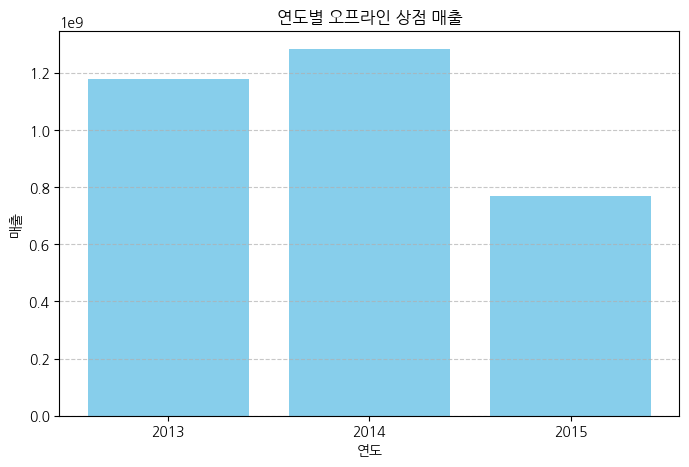

In [ ]:
# '상점명'이 'offline store'인 데이터 필터링
offline_store_df = df_daily_train_ic_names[(df_daily_train_ic_names['도시'] != '온라인') &
                                          (df_daily_train_ic_names['도시'] != '방문 판매')]

# 년도별 'offline store'의 일간매출 총합 계산
offline_store_yearly_sales = offline_store_df.groupby('년도')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(offline_store_yearly_sales['년도'], offline_store_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('매출')
plt.title('연도별 오프라인 상점 매출')
plt.xticks(offline_store_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## I. 디지털 상품 분석

### a. 디지털 상품 판매량/매출

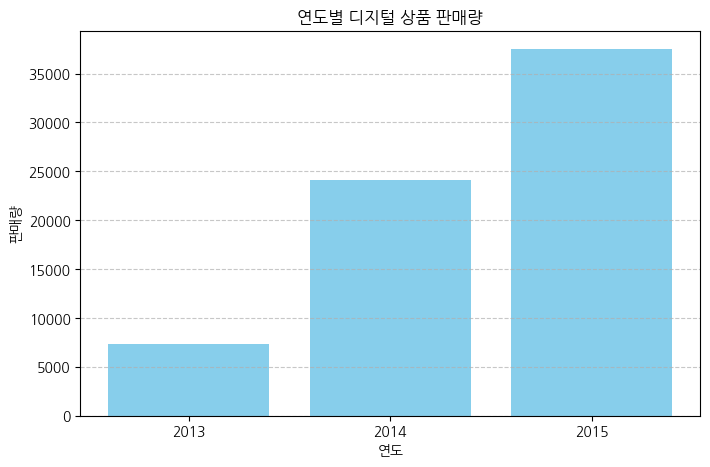

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False)]

# 연도별 '디지털'이 포함된 상품의 일간판매량 총합 계산
digital_yearly_sales = digital_products_df.groupby('년도')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['년도'], digital_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 디지털 상품 판매량')
plt.xticks(digital_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

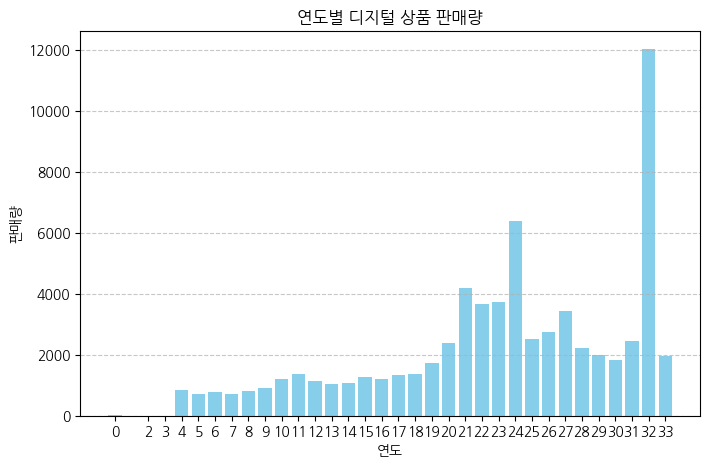

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False)]

# 월별 '디지털'이 포함된 상품의 일간판매량 총합 계산
digital_yearly_sales = digital_products_df.groupby('월ID')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['월ID'], digital_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 디지털 상품 판매량')
plt.xticks(digital_yearly_sales['월ID'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

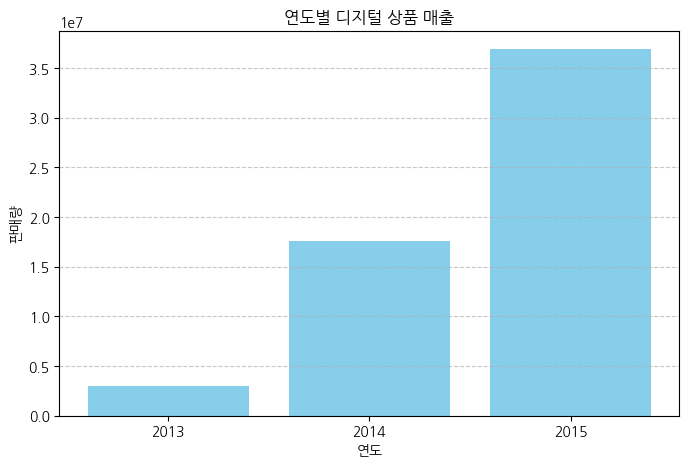

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False)]

# 연도별 '디지털'이 포함된 상품의 일간매출 총합 계산
digital_yearly_sales = digital_products_df.groupby('년도')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['년도'], digital_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 비디지털 상품 매출')
plt.xticks(digital_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### b. 비디지털 상품 판매량/매출

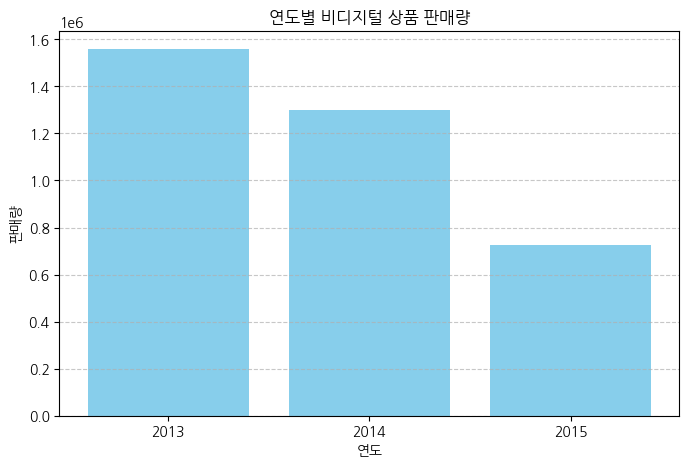

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False) == False]

# 연도별 '디지털'이 포함된 상품의 일간판매량 총합 계산
digital_yearly_sales = digital_products_df.groupby('년도')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['년도'], digital_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 비디지털 상품 판매량')
plt.xticks(digital_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

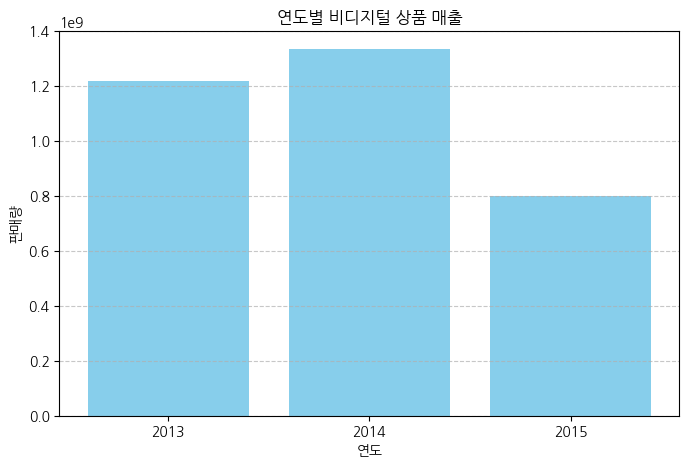

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False) == False]

# 연도별 '디지털'이 포함된 상품의 일간매출 총합 계산
digital_yearly_sales = digital_products_df.groupby('년도')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['년도'], digital_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('연도')
plt.ylabel('판매량')
plt.title('연도별 비디지털 상품 매출')
plt.xticks(digital_yearly_sales['년도'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

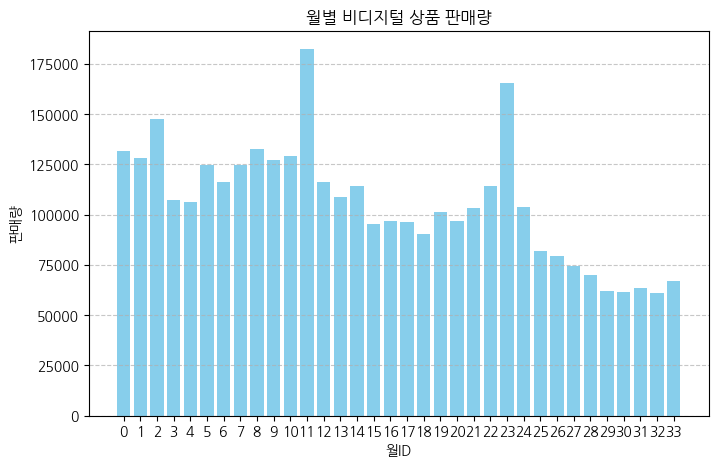

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False) == False]

# 연도별 '디지털'이 포함된 상품의 일간판매량 총합 계산
digital_yearly_sales = digital_products_df.groupby('월ID')['일간판매량'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['월ID'], digital_yearly_sales['일간판매량'], color='skyblue')
plt.xlabel('월ID')
plt.ylabel('판매량')
plt.title('월별 비디지털 상품 판매량')
plt.xticks(digital_yearly_sales['월ID'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

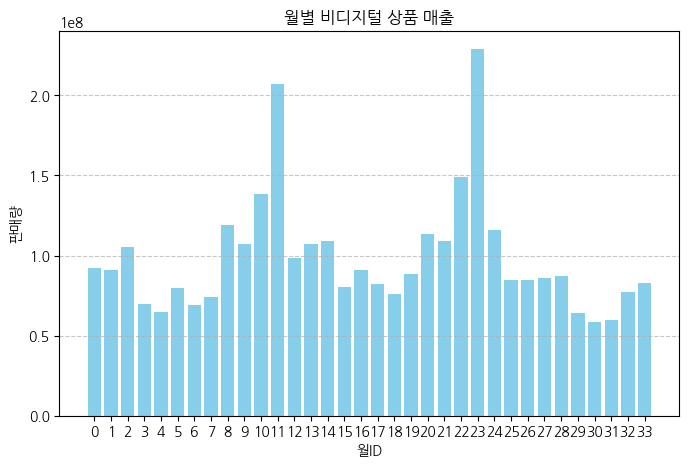

In [ ]:
# '상품명'에 '디지털'이 포함된 데이터 필터링
digital_products_df = df_daily_train_ic_names[df_daily_train_ic_names['상품명'].str.contains('디지털', na=False) == False]

# 연도별 '디지털'이 포함된 상품의 일간매출 총합 계산
digital_yearly_sales = digital_products_df.groupby('월ID')['일간매출'].sum().reset_index()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(digital_yearly_sales['월ID'], digital_yearly_sales['일간매출'], color='skyblue')
plt.xlabel('월ID')
plt.ylabel('판매량')
plt.title('월별 비디지털 상품 매출')
plt.xticks(digital_yearly_sales['월ID'])  # x축에 년도 표시
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## I. 상점별 신장률 분석

In [ ]:
# 연도별 상점별 일매출 총합 계산
store_yearly_sales = df_daily_train_ic_names.groupby(['상점명', '년도'])['일간매출'].sum().reset_index()

# 상점별로 연도별 평균 일간매출 계산
store_yearly_avg_sales = store_yearly_sales.groupby(['상점명', '년도'])['일간매출'].mean().reset_index()

# 상점별 연도별 일간매출 신장률 계산
store_yearly_avg_sales['growth_rate'] = store_yearly_avg_sales.groupby('상점명')['일간매출'].pct_change()

# 연도별 평균 일간매출 신장률이 가장 높은 상점 10개 식별
top_growth_stores = store_yearly_avg_sales.groupby('상점명')['growth_rate'].mean().nlargest(10).reset_index()

top_growth_stores

,상점명,growth_rate
0,"튜멘, ""크리스탈"" 쇼핑몰",14.25
1,디지털 창고 1C-온라인,2.78
2,"니즈니노브고로드, ""리오"" 쇼핑센터",0.84
3,"수르구트, ""시티 몰"" 쇼핑센터",0.17
4,인터넷 쇼핑몰,0.10
5,"모스크바, ""아피 몰"" 쇼핑센터",0.10
6,"볼로그다, ""마르멜라드"" 쇼핑센터",0.09
7,"발라시하, ""옥탸브르-키노미르"" 쇼핑몰",0.08
8,"아디게야, ""메가"" 쇼핑센터",0.04
9,"상트페테르부르크, ""네브스키 센터"" 쇼핑몰",0.01


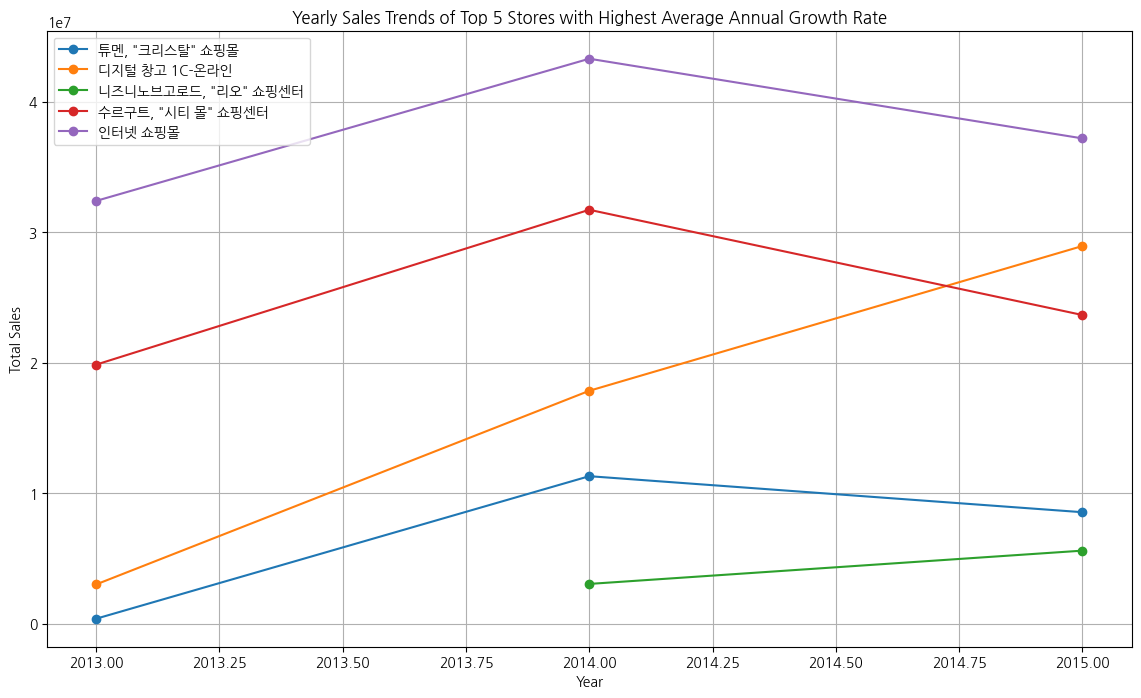

In [ ]:
# 상점별로 연도별 매출 신장률 계산
store_yearly_sales['growth_rate'] = store_yearly_sales.groupby('상점명')['일간매출'].pct_change()

# 연평균 신장률 계산
average_growth_rate = store_yearly_sales.groupby('상점명')['growth_rate'].mean().reset_index()

# 연평균 신장률이 높은 상위 5개 상점 식별
top_5_stores = average_growth_rate.nlargest(5, 'growth_rate')['상점명']

# 상위 5개 상점의 연도별 매출 변화 데이터 필터링
top_5_stores_data = store_yearly_sales[store_yearly_sales['상점명'].isin(top_5_stores)]

# 시각화
plt.figure(figsize=(14, 8))

for store in top_5_stores:
    store_data = top_5_stores_data[top_5_stores_data['상점명'] == store]
    plt.plot(store_data['년도'], store_data['일간매출'], marker='o', label=store)

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Yearly Sales Trends of Top 5 Stores with Highest Average Annual Growth Rate')
plt.legend()
plt.grid(True)
plt.show()

## J. 상점 형태 분석

In [ ]:
# 상점 형태별 개수, 비율 계산
unique_city = df_daily_train['도시'].unique()
len_total = len(unique_city)
len_online = len_visit = 1
len_offline = len_total - len_online - len_visit

print('전체 데이터 수:', len_total)
print(f'온라인 상점 데이터 수: {len_online} ({100.0 * len_online / len_total:.2f}%)')
print(f'방문 판매 데이터 수: {len_visit} ({100.0 * len_visit / len_total:.2f}%)')
print(f'오프라인 상점 데이터 수: {len_offline} ({100.0 * len_offline / len_total:.2f}%)')

전체 데이터 수: 30
온라인 상점 데이터 수: 1 (3.33%)
방문 판매 데이터 수: 1 (3.33%)
오프라인 상점 데이터 수: 28 (93.33%)


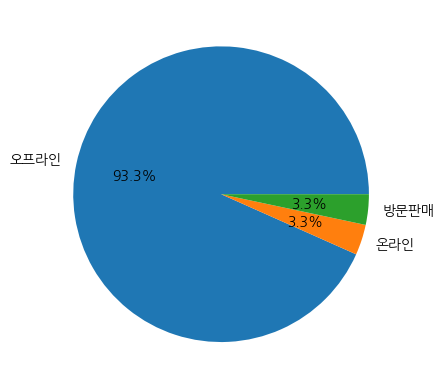

In [ ]:
# 시각화
x = [len_offline, len_online, len_visit]
labels = ['오프라인', '온라인', '방문판매']

plt.pie(x=x, labels=labels, autopct='%.1f%%');

In [ ]:
# 상점 형태별 판매 건수, 비율 계산
len_total = len(df_daily_train)
len_online = len(df_daily_train[df_daily_train['도시'] == '온라인'])
len_visit = len(df_daily_train[df_daily_train['도시'] == '방문 판매'])
len_offline = len_total - len_online - len_visit

print('전체 데이터 수:', len_total)
print(f'온라인 상점 데이터 수: {len_online} ({100.0 * len_online / len_total:.2f}%)')
print(f'방문 판매 데이터 수: {len_visit} ({100.0 * len_visit / len_total:.2f}%)')
print(f'오프라인 상점 데이터 수: {len_offline} ({100.0 * len_offline / len_total:.2f}%)')

전체 데이터 수: 2928483
온라인 상점 데이터 수: 69028 (2.36%)
방문 판매 데이터 수: 3743 (0.13%)
오프라인 상점 데이터 수: 2855712 (97.52%)


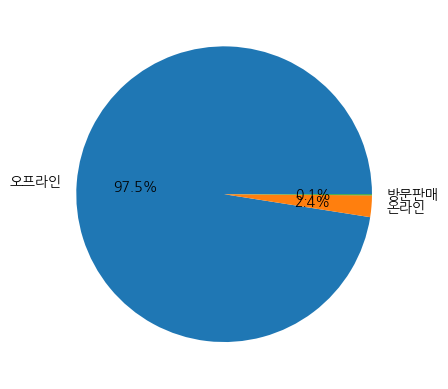

In [ ]:
# 시각화
x = [len_offline, len_online, len_visit]
labels = ['오프라인', '온라인', '방문판매']

plt.pie(x=x, labels=labels, autopct='%.1f%%');